# Blackbody Radiation

#### This notebook demonstrates the tools needed to extract physical information from radio astronomy observations.

Let's start with creating the function of the Blackbody radiation. The coefficient is normalised to unity, converting the units of $B_v$ to arbitrary units. Otherwise the order of magnitude would be lower than the machine precision.

A list of different temperature values is created to demonstrate the family of curves of $B_v (v;T)$. With black vertical lines we mark the spectral window we intend to observe through our radiotelescope. We can notice that only very low temperatures correspond to curves whose peak is inside $1-50 GHz$. This can also be displayed using the Wien law.

The Blackbody source function is:

$$B_v(v;T) = \frac{2 h v^3}{c^2} \frac{1}{e^{\frac{hv}{kT}}-1}$$

The following commands must be run before running the rest of the notebook for the first time

In [74]:
# %pip install scikit-learn
# %pip install specutils
# %pip install numpy
# %pip install matplotlib
# %pip install scipy
# %pip install pandas
# %pip install astropy

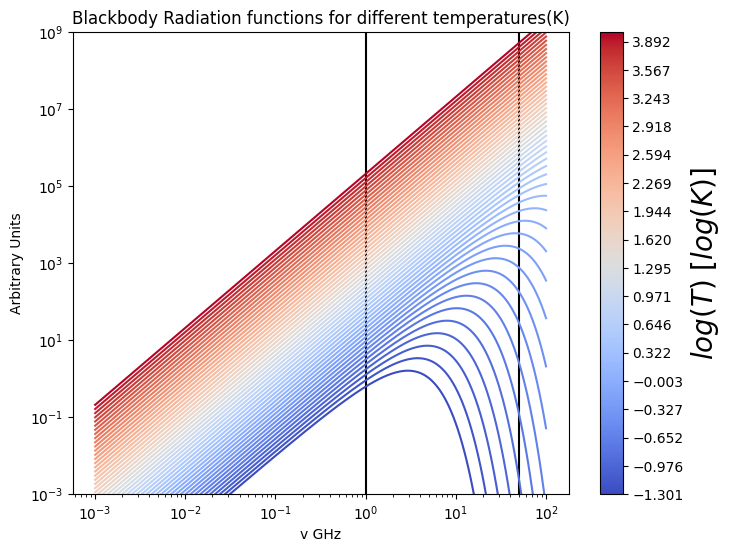

In [75]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def Bv(v, T):
    # coeff = 2*h/c**2
    coeff = 1
    # power = h /(k)
    power = 6.62607015/1.380649 *10**(-2)
    # 2*h *v**3 /c**2
    # h*v /(k*T)
    result = (coeff * (v)**3) * 1/(np.exp(power *v/T) -1)
    return result

# h = Placnk constant
h = 6.62607015*10**(-34) # J*Hz**(-1)
# Speed of light in a vacuum
c = 299792458 #m/s
# Boltzmann constant
k = 1.380649*10**(-23) #J*K**(−1)

# b = 2.897771955*10**3 #m*K
# b = h*c/k *1/(5+Wo*(-5*np.exp(-5)))

Y_vert = np.geomspace(10**(-3), 10**9, 100)
X_vert1 = np.ones(len(Y_vert))
X_vert2 = np.ones(len(Y_vert))*50

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(X_vert1, Y_vert, color = 'k', label = "Area of interest")
ax.plot(X_vert2, Y_vert, color = 'k')

# Absolute temperatures of the body
# temp = [5e-2, 1e-1, 0.4, 1, 2.7, 10, 100, 1000, 10000] 
temp = np.geomspace(5e-2, 10000, 50)
log_T = np.log10(temp)

X0 = 100
X = np.geomspace(0.001 , X0, 200)

norm = mpl.colors.Normalize(vmin=min(log_T), vmax=max(log_T))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])

for i,T in enumerate(temp):
    # lpeak = b/T
    # vpeak = T*5.879*10**10
    Y = Bv(X, T)
    
    ax.plot(X, Y, color=cmap.to_rgba(log_T[i]))

cbar = fig.colorbar(cmap, ticks=log_T[::3], ax=ax)
cbar.set_label('$log(T)$ [$log(K)$]', fontsize = 20, rotation=90)

plt.yscale('log')
plt.xscale('log')
plt.ylim(10**(-3), 10**9)
plt.xlabel("v GHz")
plt.ylabel("Arbitrary Units")
plt.title("Blackbody Radiation functions for different temperatures(K)")
plt.show()


#### Picking variables for our signal <br> (T = Temperature, [X0,X1] = Area of signal and X0>0, N = Sample size)

In [76]:
T = temp[1]
X0 = 10e-3
X1 = 100
N = 500
X = np.geomspace(X0 , X1, N)
clean = Bv(X, T)
print("My temperature is: ", T, "K")

My temperature is:  0.06414374168661295 K


#### Generating noise and plotting it's histogram

Text(0, 0.5, 'Number of points')

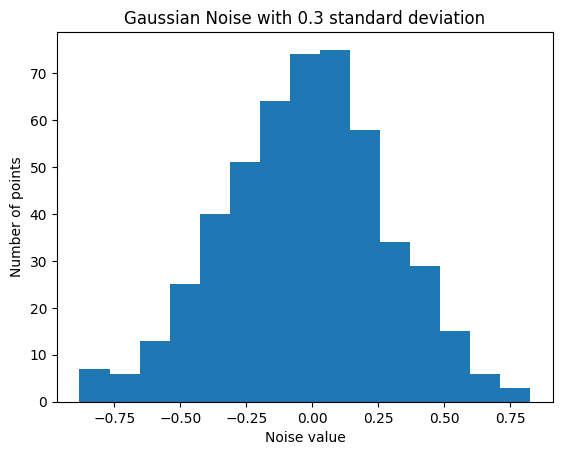

In [77]:
factor = 4 #division of gaussian noise by factor
spread = 0.3 #spread/scale of gaussian noise

# Trick for now
# noise = np.random.normal(0,0.3,len(clean))
noise = np.random.normal(0,spread,len(clean))

plt.hist(noise, bins = 15)
noise = noise/factor
signal = clean + noise*clean

plt.title("Gaussian Noise with 0.3 standard deviation")
plt.xlabel("Noise value")
plt.ylabel("Number of points")


#### Adding gaussian noise

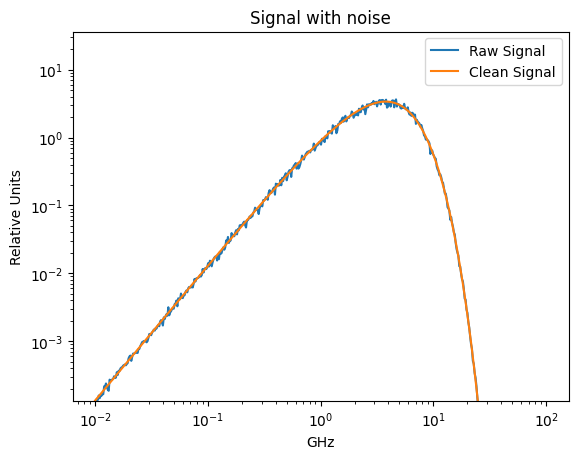

In [78]:
import random

# meanSignal = signal.copy()
# for i in range(0, len(noise)):
#     meanSignal[i] = np.nanmedian(signal[i:i+5])

# meanSignal = np.abs(meanSignal)

plt.title("Signal with noise")
plt.xlabel("GHz")
plt.ylabel("Relative Units")
plt.plot(X, signal, label = "Raw Signal")
plt.plot(X, clean, label = "Clean Signal")
# plt.plot(X, meanSignal, label = "Median")
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim(signal[0], max(signal)*10)
plt.show()

#### Simulating Spectral lines with Gaussian

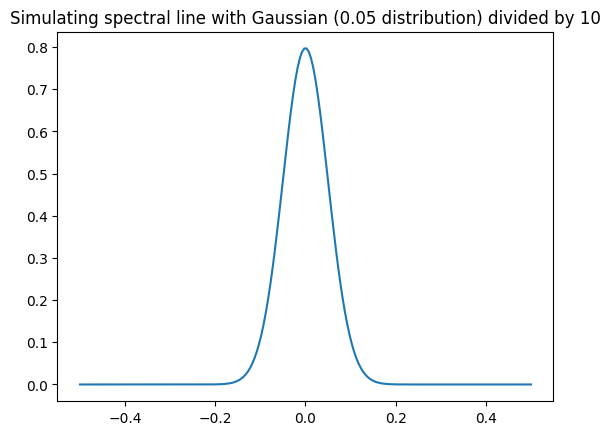

In [79]:
from scipy.stats import norm
spread_spectral = 0.05 #scale/spread of gaussian distribution
factor_spectral = 10 #division of gaussian distribution by factor

domain = np.linspace(-0.5, 0.5, num=200)
gauss = norm.pdf(domain, 0, spread_spectral)/factor_spectral

plt.title("Simulating spectral line with Gaussian (0.05 distribution) divided by 10")
plt.plot(domain, gauss)
plt.show()


#### Adding spectral lines

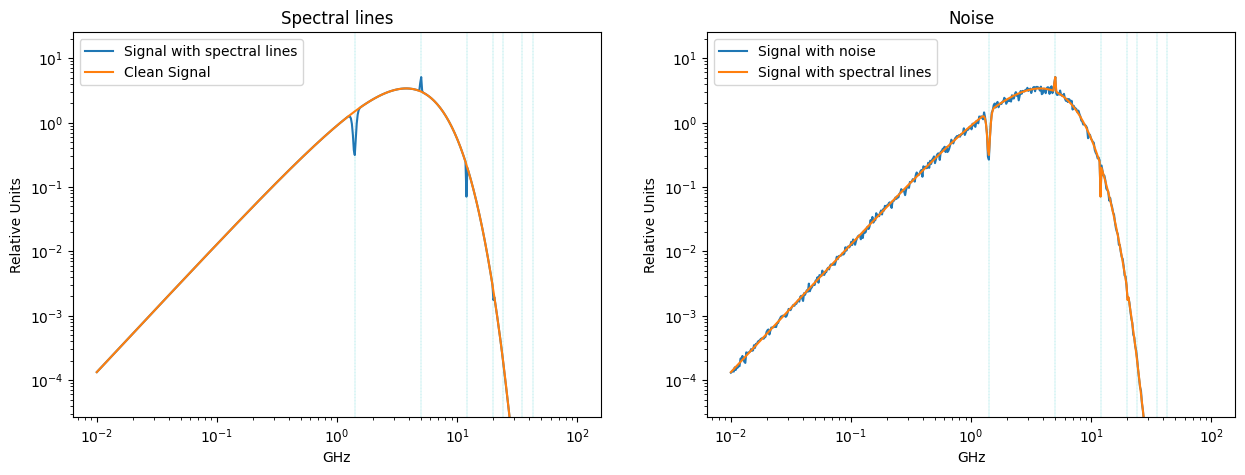

In [80]:
from scipy.stats import norm

# Trick for now
# noise = np.random.normal(0,0.3,len(clean))
# signal = clean + noise*clean/4

spectral_lines = np.array([1.4, 5, 12, 20, 24, 35, 43])

fig, ax = plt.subplots(1,2, figsize=(15,5))

for i in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[i]) <=0.5)]
    X_cords = [X[j] for j in points]
    gauss = norm.pdf(X_cords, spectral_lines[i], 0.05)/10
    sign = random.randrange(-1,2,2)
    
    for j,k in enumerate(points):
        clean[k] += sign*gauss[j]*clean[k]
        signal[k] += sign*gauss[j]*signal[k]
    
    Y_vert = np.geomspace(10e-11, max(clean)*10, 100)
    X_vert = np.ones(len(Y_vert))*spectral_lines[i]
    
    ax[0].plot(X_vert, Y_vert, '--', lw=0.2, color = 'c')
    ax[1].plot(X_vert, Y_vert, '--', lw=0.2, color = 'c')

ax[0].set_title("Spectral lines")
ax[0].set_xlabel("GHz")
ax[0].set_ylabel("Relative Units")
ax[0].plot(X, clean, label = "Signal with spectral lines")
ax[0].plot(X, Bv(X, T), label="Clean Signal")
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim(clean[0]/5, max(clean)*5)
# ax[0].set_ylim(10e-8, max(clean)*5)

ax[1].set_title("Noise")
ax[1].set_xlabel("GHz")
ax[1].set_ylabel("Relative Units")
ax[1].plot(X, signal, label = "Signal with noise")
ax[1].plot(X, clean, label="Signal with spectral lines")
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylim(clean[0]/5, max(clean)*5)
# ax[1].set_ylim(10e-8, max(clean)*5)
# plt.ylim(10e-8,10e-7)
# plt.xlim(34.9, 35.1)
plt.show()

Now each spectrum is ready for fitting. But before attempting so, one can notice an interesting fact regarding the family of curves shown above. When the peak is located in large enough frequencies, in comparison to the window of interest, the curve seems like a straight line. This can be shown indeed, from a first order Taylor expansion, for $\frac{hv}{kT} << 1$:
$$ B_v(v;T) = \frac{2 h v^3}{c^2} \frac{1}{e^{\frac{hv}{kT}}-1} \simeq \frac{2 h v^3}{c^2} \frac{1}{1+\frac{hv}{kT}+\mathcal{O}((\frac{hv}{kT})^2)-1}$$

$$ B_v(v;T) \simeq \frac{2 h v^3}{c^2} \frac{kT}{hv} $$

$$ B_v(v;T) \simeq \frac{2 kT v^2}{c^2} $$

$$ log(B_v(v;T)) \simeq log(\frac{2 kT }{c^2}) + 2log(v) $$

Hence, it is obvious that one can fit a line to the logarithmic data and extract the temperature from its coefficient.

Here, we use a different approach, exploiting the scipy.optimize.curve_fit() and fitting two functions: $f(v;T) = B_v(v;T)$ and $f(v;a) = a*v^2$.

Choosing a relatively large temperature value and zooming in the window of interest, we can see the performance of each fit.

### **Picking variables to create signal** 
We will use a big temperature to create a linear signal

In [81]:
T = 1e4   #K
X0 = 10 #Ghz
X1 = 100 #Ghz
N = 200

X = np.geomspace(X0 , X1, N)
Y = Bv(X, T)
# noise = np.random.random(len(Y))-1/2
noise = np.random.normal(0,spread,len(Y))/factor
signal = Y + noise*Y

#### Fitting signal with Blackbody and Quadratic functions

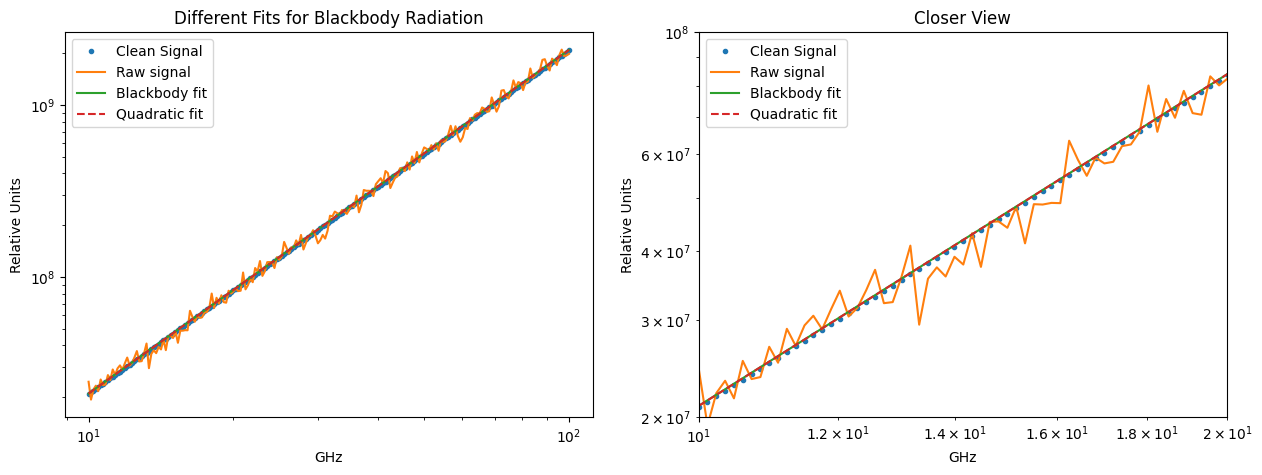

In [82]:
from scipy import optimize

def quadratic(x, a):
    return a*x**2

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(X, Y, '.',label = "Clean Signal")
ax[0].plot(X, signal, label = "Raw signal")

popt, pcov = optimize.curve_fit(Bv, X, signal)
popt1, pcov1 = optimize.curve_fit(quadratic, X, signal)

ax[0].set_yscale('log')
ax[0].set_xscale('log')
# ax[0].xlim(10**9, 50*10**9)
# ax[0].ylim(10**-26, Bv(100000, vpeak)*10)
ax[0].set_title("Different Fits for Blackbody Radiation")
ax[0].plot(X, Bv(X, *popt), label = "Blackbody fit")
ax[0].plot(X, quadratic(X, *popt1), '--', label = "Quadratic fit")
ax[0].set_xlabel("GHz")
ax[0].set_ylabel("Relative Units")
ax[0].legend()

ax[1].plot(X, Y, '.',label = "Clean Signal")
ax[1].plot(X, signal, label = "Raw signal")

popt, pcov = optimize.curve_fit(Bv, X, signal)
popt1, pcov1 = optimize.curve_fit(quadratic, X, signal)

ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(10, 20)
ax[1].set_ylim(2*10**7, 10**8)
ax[1].set_title("Closer View")
ax[1].plot(X, Bv(X, *popt), label = "Blackbody fit")
ax[1].plot(X, quadratic(X, *popt1), '--', label = "Quadratic fit")
ax[1].set_xlabel("GHz")
ax[1].set_ylabel("Relative Units")
ax[1].legend()

plt.show()

#### We can see that fitting the whole line producing very small error.
We want to isolate regions to simulate smaller sample size

In [83]:
T_Bv = popt[0]
power = 6.62607015/1.380649 *10**(-2)
T_quadr = popt1[0]*power
per_Bv = np.abs(T-T_Bv)/T *100
per_quadr = np.abs(T-T_quadr)/T *100

print("Real temperature value:", round(T,2),"K")
print("Without Spectral Lines:", T_Bv,"K")
# print("With Spectral Lines:   ", popt_spectral[0],"K")
# print("Filtered Signal:       ", popt[0],"K")
print("The absolute relative percentage error for")
# print("B_v: \t",round(per_raw,2),"%")
# print("B_v: \t",round(per_spectral,2),"%")
print("B_v: \t",round(per_Bv,2),"%")
# if(quad):
    # print("Square:\t",round(per_quadr,2),"%")


Real temperature value: 10000.0 K
Without Spectral Lines: 10060.205552837038 K
The absolute relative percentage error for
B_v: 	 0.6 %


##### We can see that the square function fitting demonstrates a better perfomance when seeking the temperature parameter.
Of course, one can try the conventional way with linear fitting on log data, based on the relation:
$$ log(B_v(v;T)) \simeq log(\frac{2 kT }{c^2}) + 2log(v) $$
$$ y = b + ax $$

coefficient of determination: 0.9920625339853671
intercept: 4.7650999801282214
slope: [0.59272221]


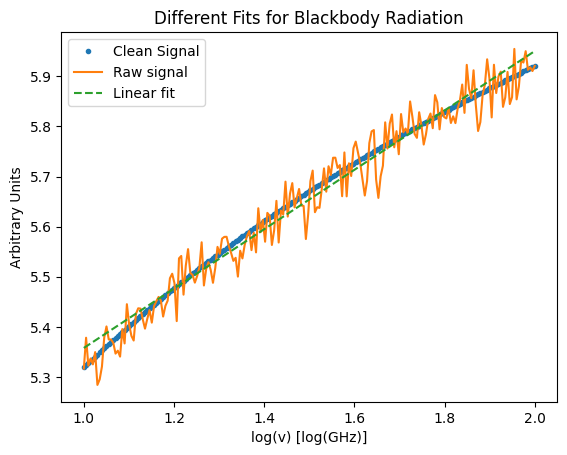

In [84]:
from sklearn.linear_model import LinearRegression

X0 = 100
X = np.log10(np.geomspace(10 , X0, 200))

# T = temp[45]
Y = Bv(X, T)
# noise = np.random.random(len(Y))-1/2
noise = np.random.normal(0,spread,len(Y))/factor
signal = np.log10(Y + noise*Y)

Y = np.log10(Y)

X = np.array([X]).T
model = LinearRegression()
model.fit(X, Y)

r_sq = model.score(X, Y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

Y_pred = model.predict(X)

X = X.T[0]


plt.plot(X, Y, '.',label = "Clean Signal")
plt.plot(X, signal, label = "Raw signal")
plt.plot(X,Y_pred, '--', label = "Linear fit")
plt.title("Different Fits for Blackbody Radiation")

# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(10**9, 50*10**9)
# plt.ylim(10**-26, Bv(100000, vpeak)*10)

plt.xlabel("log(v) [log(GHz)]")
plt.ylabel("Arbitrary Units")
plt.legend()
plt.show()

#### Pick temperature and sample size

In [85]:
import random

T = 1e4   #K
# T = temp[1] #Κ
N = 10000 

X0 = 100
X = np.linspace(10e-3, X0, N)
# X = np.geomspace(10e-3 , X0, 10000)
clean = Bv(X, T)

# Trick for now
noise = np.random.normal(0,spread,len(clean))/factor
signal = clean + noise*clean
raw = signal.copy()

# meanSignal = signal.copy()
# for i in range(0, len(noise)):
#     meanSignal[i] = np.nanmedian(signal[i:i+5])

# meanSignal = np.abs(meanSignal)

#### Printing new signal

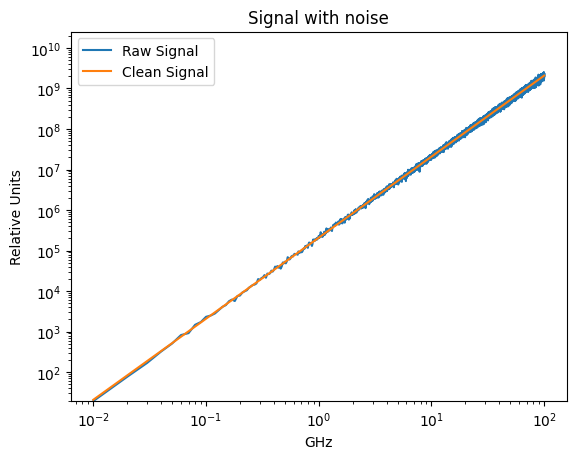

In [86]:
plt.title("Signal with noise")
plt.xlabel("GHz")
plt.ylabel("Relative Units")
plt.plot(X, signal, label = "Raw Signal")
plt.plot(X, clean, label = "Clean Signal")
# plt.plot(X, meanSignal, label = "Median")
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylim(signal[0], max(signal)*10)
plt.show()

#### Fitting only with noise

In [87]:
popt, pcov = optimize.curve_fit(Bv, X, signal)

quad = False
if(signal[0]<signal[-1]):
    quad = True

T_Bv = popt[0]
per_Bv = np.abs(T-T_Bv)/T *100
    
print("Real temperature value:", round(T,2),"K")
print("Filtered Signal:       ", popt[0],"K")
print("The absolute relative percentage error for")
print("B_v: \t",round(per_Bv,2),"%")
if(quad):
    print("Square:\t",round(per_quadr,2),"%")

Real temperature value: 10000.0 K
Filtered Signal:        9992.713339417087 K
The absolute relative percentage error for
B_v: 	 0.07 %
Square:	 0.58 %


#### Adding spectral lines

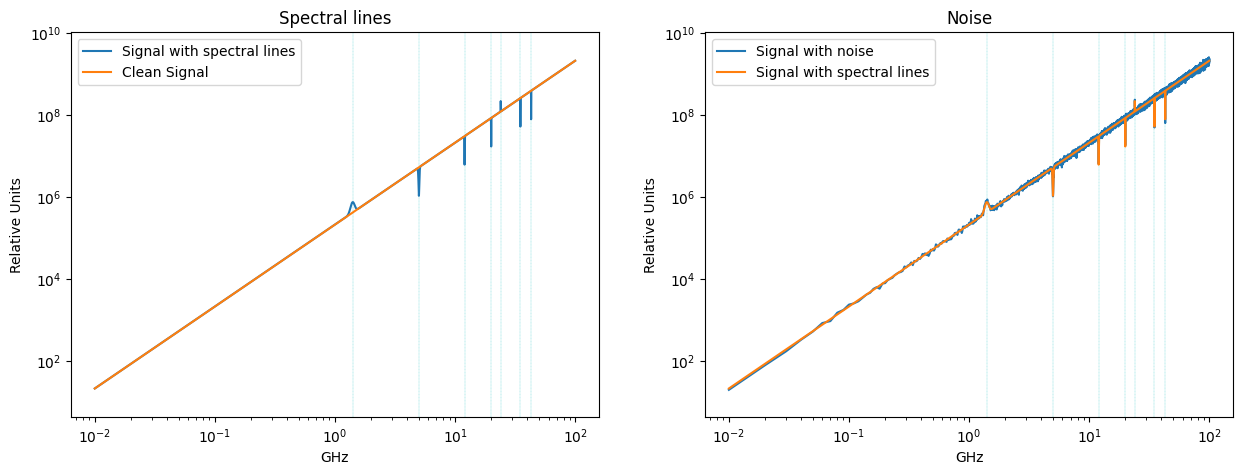

In [88]:
from scipy.stats import norm

# Trick for now
# noise = np.random.normal(0,0.3,len(clean))
# signal = clean + noise*clean/4

spectral_lines = np.array([1.4, 5, 12, 20, 24, 35, 43])

fig, ax = plt.subplots(1,2, figsize=(15,5))

for i in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[i]) <=0.5)]
    X_cords = [X[j] for j in points]
    gauss = norm.pdf(X_cords, spectral_lines[i], 0.05)/10
    sign = random.randrange(-1,2,2)
    
    for j,k in enumerate(points):
        clean[k] += sign*gauss[j]*clean[k]
        signal[k] += sign*gauss[j]*signal[k]
    
    Y_vert = np.geomspace(10e-11, max(clean)*10, 100)
    X_vert = np.ones(len(Y_vert))*spectral_lines[i]
    
    ax[0].plot(X_vert, Y_vert, '--', lw=0.2, color = 'c')
    ax[1].plot(X_vert, Y_vert, '--', lw=0.2, color = 'c')

ax[0].set_title("Spectral lines")
ax[0].set_xlabel("GHz")
ax[0].set_ylabel("Relative Units")
ax[0].plot(X, clean, label = "Signal with spectral lines")
ax[0].plot(X, Bv(X, T), label="Clean Signal")
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim(clean[0]/5, max(clean)*5)
# ax[0].set_ylim(10e-8, max(clean)*5)

ax[1].set_title("Noise")
ax[1].set_xlabel("GHz")
ax[1].set_ylabel("Relative Units")
ax[1].plot(X, signal, label = "Signal with noise")
ax[1].plot(X, clean, label="Signal with spectral lines")
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylim(clean[0]/5, max(clean)*5)
# ax[1].set_ylim(10e-8, max(clean)*5)
# plt.ylim(10e-8,10e-7)
# plt.xlim(34.9, 35.1)
plt.show()

## 2.Showing spectral lines without noise

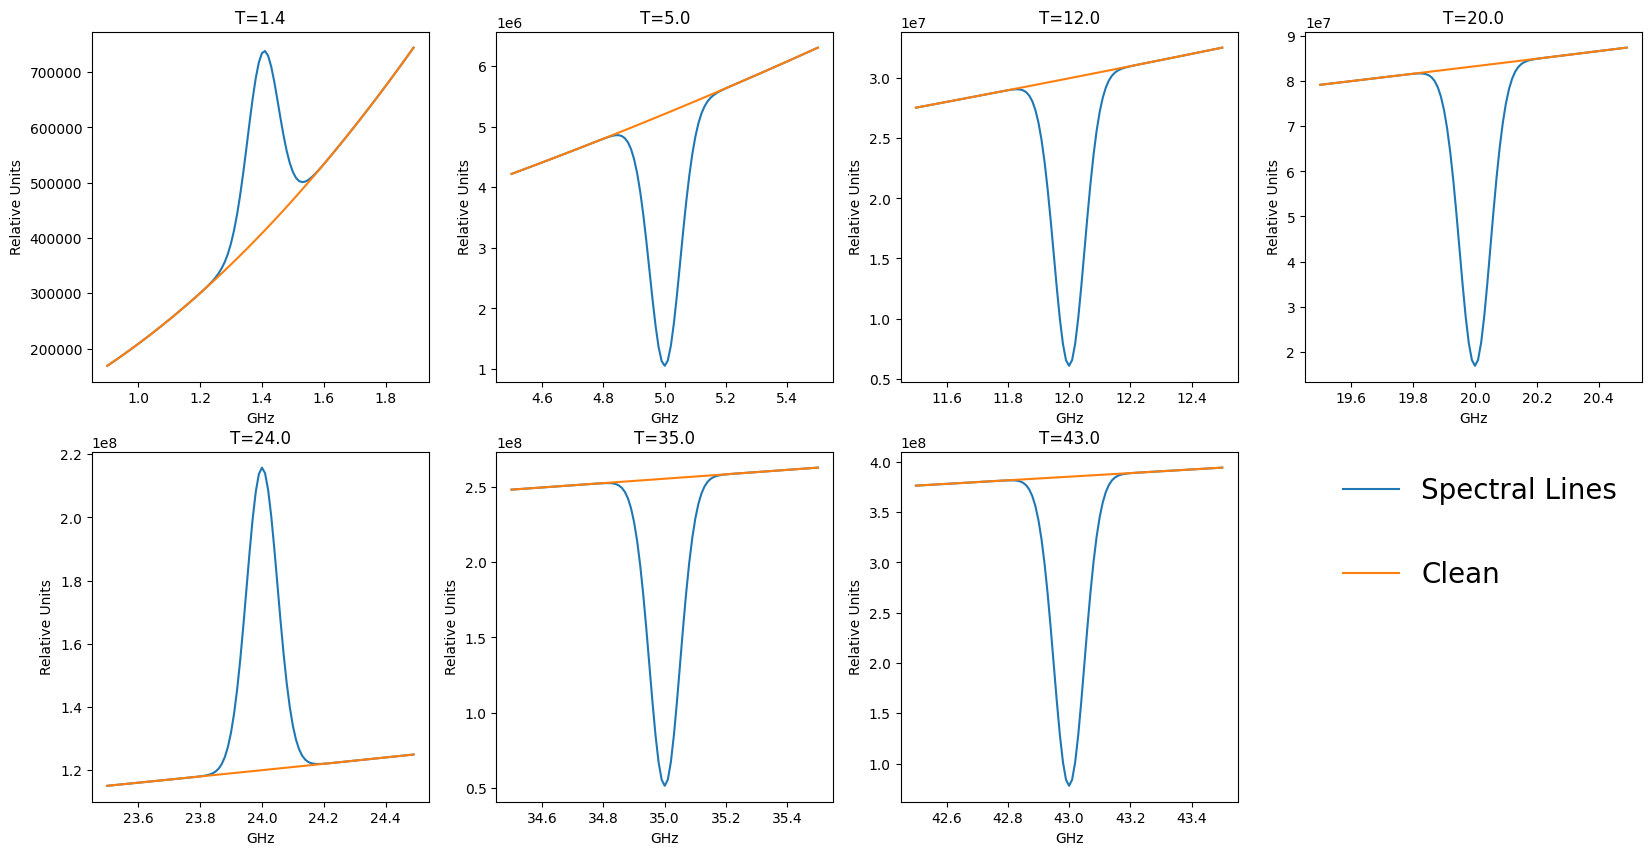

In [89]:
from scipy.stats import norm

# X0 = 100
# X = np.geomspace(10e-3 , X0, 50000)
# clean = Bv(X, T)
# lines = clean

spectral = clean.copy()

# spectral_lines = np.array([1.4, 5, 12, 20, 24, 35, 43])
fig, ax = plt.subplots(2,4,figsize = (20,10))

for i in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[i]) <=0.5)]
    X_cords = np.array([X[j] for j in points])
    # gauss = norm.pdf(X_cords, spectral_lines[i], 0.05)/10
    # sign = random.randrange(-1,2,2)
    
    # for j,k in enumerate(points):
    #     lines[k] += sign*gauss[j]*lines[k]
    
    axis = ax[i//4, i%4]
    axis.plot(X_cords, spectral[points[0]:points[-1]+1], label="Spectral Lines")
    axis.plot(X_cords, Bv(X_cords, T), label="Clean")
    axis.set_title("T="+str(spectral_lines[i]))
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

handles, labels = axis.get_legend_handles_labels()
ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()

#### Showing spectral lines with noise

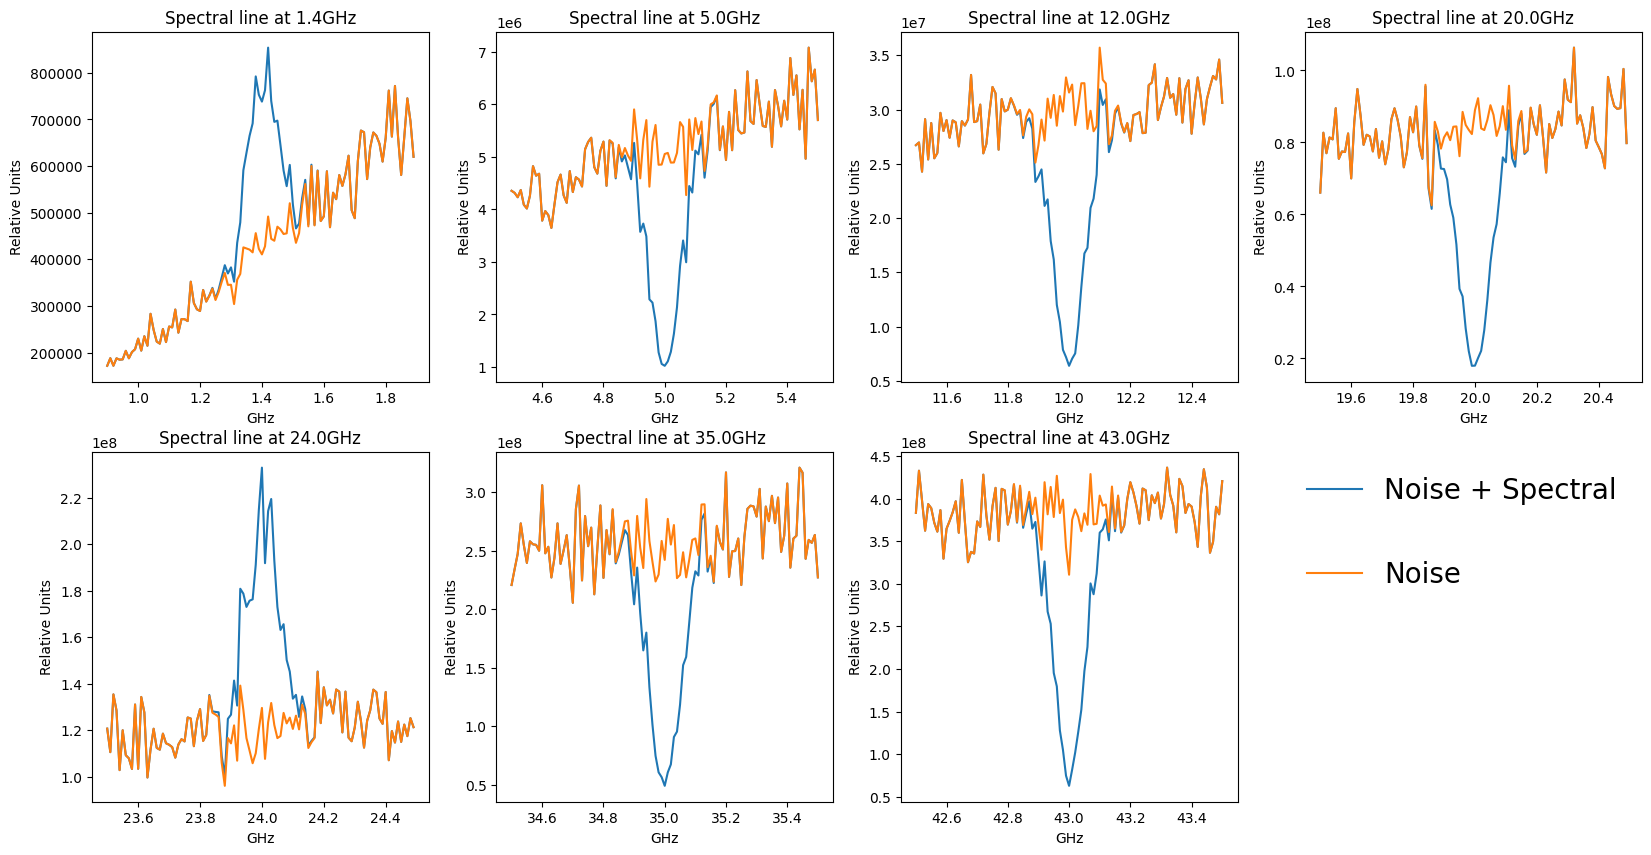

In [90]:
from scipy.stats import norm

# signal = clean + noise*clean/4
# raw = Bv(X, T) + noise*Bv(X, T)/4

# spectral_lines = np.array([1.4, 5, 12, 20, 24, 35, 43])
fig, ax = plt.subplots(2,4,figsize = (20,10))

for i in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[i]) <=0.5)]
    X_cords = np.array([X[j] for j in points])
   
    axis = ax[i//4, i%4]
    # axis.plot(X_cords, spectral[points[0]:points[-1]+1], label="Spectral Lines")
    axis.plot(X_cords, signal[points[0]:points[-1]+1], label="Noise + Spectral")
    axis.plot(X_cords, raw[points[0]:points[-1]+1], label="Noise")
    axis.set_title("Spectral line at "+str(spectral_lines[i])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

handles, labels = axis.get_legend_handles_labels()
ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()

#### Smoothing our signal by implementing rolling mean

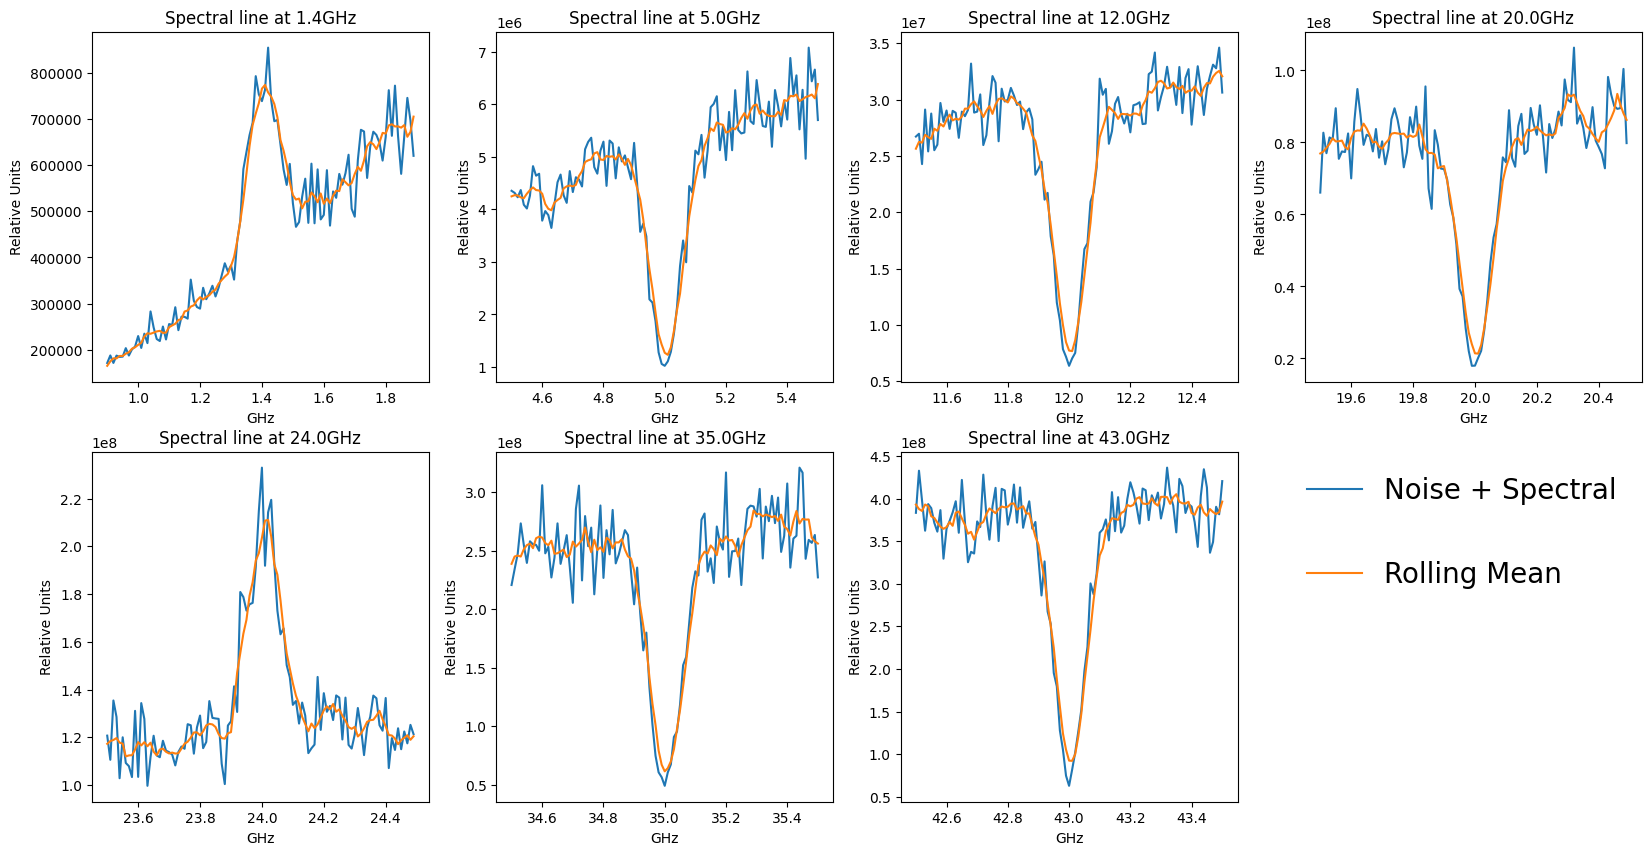

In [91]:
from scipy.stats import norm

# signal = clean + noise*clean/4
# raw = Bv(X, T) + noise*Bv(X, T)/4

# spectral_lines = np.array([1.4, 5, 12, 20, 24, 35, 43])
fig, ax = plt.subplots(2,4,figsize = (20,10))

for i in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[i]) <=0.5)]
    X_cords = np.array([X[j] for j in points])
   
    axis = ax[i//4, i%4]
    mean = [np.nanmean(signal[point-3:point+3]) for point in points]
    axis.plot(X_cords, signal[points[0]:points[-1]+1], label="Noise + Spectral")
    axis.plot(X_cords, mean, label="Rolling Mean")
    # axis.plot(X_cords, raw[points[0]:points[-1]+1], label="Noise")
    axis.set_title("Spectral line at "+str(spectral_lines[i])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

handles, labels = axis.get_legend_handles_labels()
ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()

In [92]:
noise = np.random.normal(0,spread,len(clean))/factor
clean = signal.copy()

### 2.1 Applying threshold method to find spectral lines

This is an inefficient but simple method that we implemented in order to
better understand how to find patterns in a signal in order to find a spectral
line.

This method identifies a spectral line by detecting values in the signal
that deviate the most from the most common values. 

In order to compare
the values among themselves, we need to normalize the signal. 
Therefore, we calculate an approximation(fit) of the signal and subtract it from the signal.

Then, we determine which values are the most common with the help of a
histogram and define a range of median values. 
With the aid of the specified
range, we find the largest area formed by contiguous points outside of the
median values, which corresponds to the spectral line. 

The problem with
this method is that it misses the actual start and end of the spectral line
because they are between the range of median values. 
Therefore, the length
of the spectral line that is detected is always smaller that it’s actual length.
That means that this method produces a result with an incorporated error,
so we had to search for a better method.

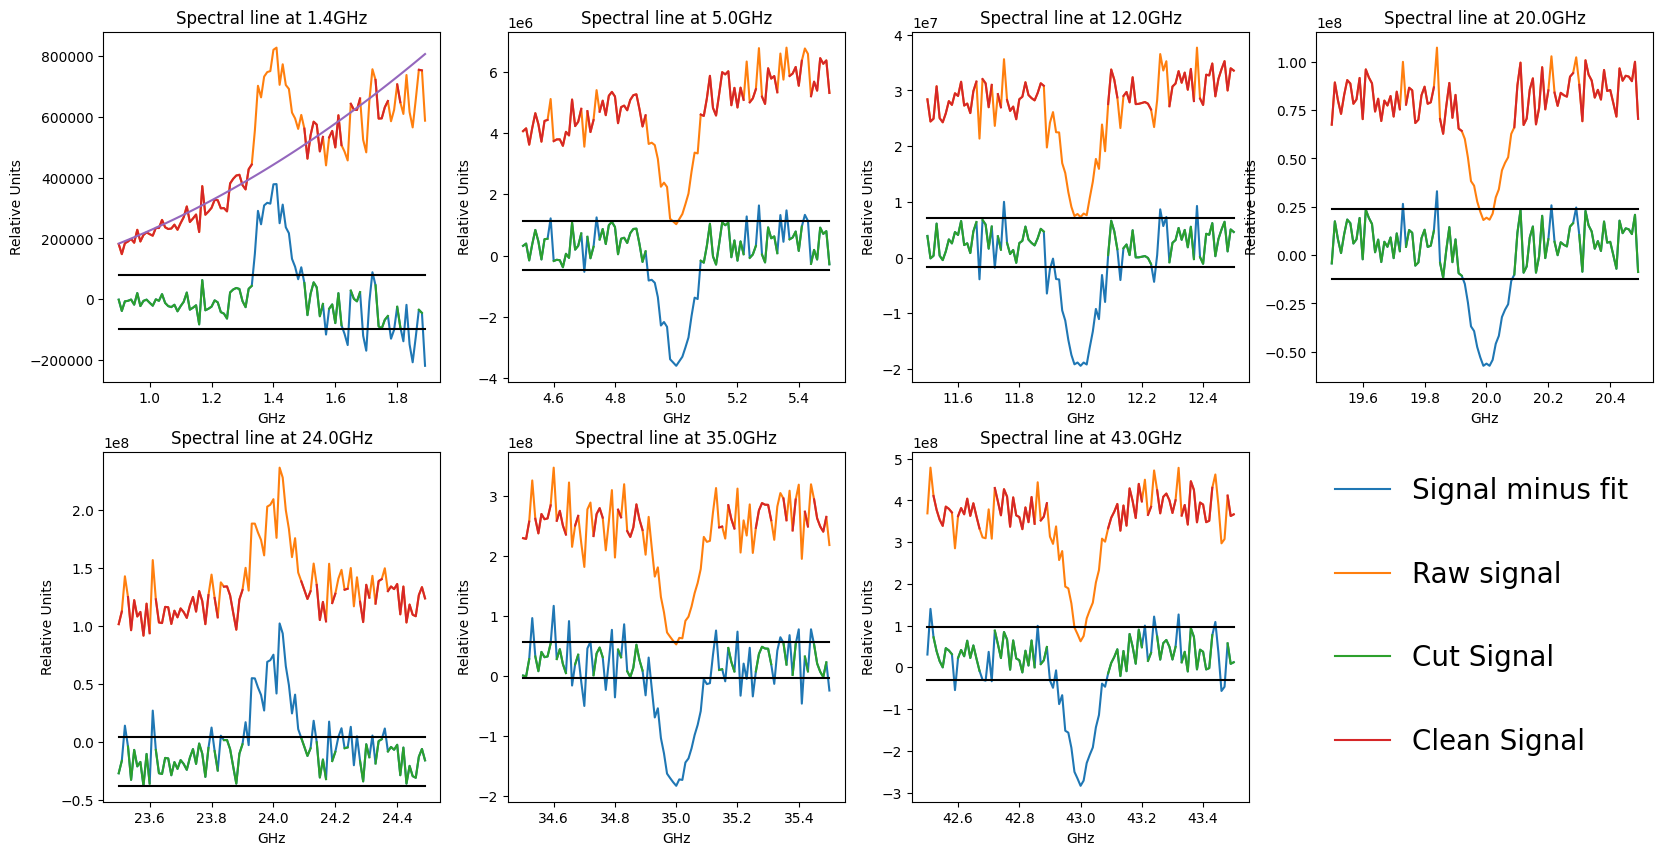

In [93]:
from scipy.stats import norm
from scipy import optimize
import pandas as pd

def quadratic(x, a):
    return a*x**2

pd.options.mode.chained_assignment = None  # default='warn'

# spectral_lines = np.array([1.4, 5, 12, 20, 24, 35, 43])S

# Trick for now
signal = clean + noise*clean

fig, ax = plt.subplots(2,4,figsize = (20,10))

df = 0
df = [pd.DataFrame({}) for i in range(len(spectral_lines))]

for line in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    # quad = False
    # if(signal[points[0]]<signal[points[-1]]):
    quad = True
    
    df[line]['X'] = np.array([X[j] for j in points])
    df[line]['signal'] = signal[points[0]:points[-1]+1]
    median = [np.nanmean(signal[point-3:point+3]) for point in points]
    df[line]['median'] = np.array(median)
    step = int(len(points)/10)

    popt, pcov = optimize.curve_fit(Bv, df[line]['X'], df[line]['signal'])
    if(quad):
        popt1, pcov1 = optimize.curve_fit(quadratic, df[line]['X'], df[line]['signal'])

    df[line]['cut'] = df[line]['signal'] - Bv(df[line]['X'], *popt)
    flag = False

    h= np.histogram(df[line]['cut'])
    new_h = list()
    bin = h[1][0]-h[1][1]

    for j, c in enumerate(h[0]):
        if(c >= 15):
            new_h.append(h[1][j])
            last = j

    new_h.append(max(new_h)-bin)
    new_h = np.sort(new_h)

    df[line]['minus'] = df[line]['cut'] 
    df[line]['out'] = [False for i in df[line]['X']] 

    for j, y in enumerate(df[line]['cut']):
        if(y > new_h[-1]):
            df[line]['cut'][j] = np.nan
            df[line]['out'][j] = True
        if(y < new_h[0]):
            df[line]['cut'][j] = np.nan
            df[line]['out'][j] = True

    df[line]['clean'] = df[line]['cut'] + Bv(df[line]['X'], *popt)

    axis = ax[line//4, line%4]

    axis.plot(df[line]['X'], df[line]['minus'], label="Signal minus fit")
    axis.plot(df[line]['X'], df[line]['signal'], label="Raw signal")
    axis.plot(df[line]['X'], df[line]['cut'], label="Cut Signal")
    axis.plot(df[line]['X'], df[line]['clean'], label="Clean Signal")
    axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[0], color='#000000')
    axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[-1], color='#000000')
    # axis.plot(X[points[start]:points[stop]], signal[points[start]:points[stop]], label ="Spectral Lines")
    # clean[points[0]:points[-1]+1] = df[line]['clean'].values
    # axis.plot(df[line]['X'], clean[points[0]:points[-1]+1])
    if(line == 0):
        axis.plot(df[line]['X'], Bv(df[line]['X'], *popt), label = "Blackbody fit")
    # if(quad):
    #     axis.plot(X_cords, quadratic(X_cords, *popt1), "--", label = "Quadratic fit")
    #     handles, labels = axis.get_legend_handles_labels()
    # axis.plot(X_cords, clean[points[0]:points[-1]+1], label='clean')
    axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

handles, labels = axis.get_legend_handles_labels()
ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()

### 2.2 Finding spectral lines

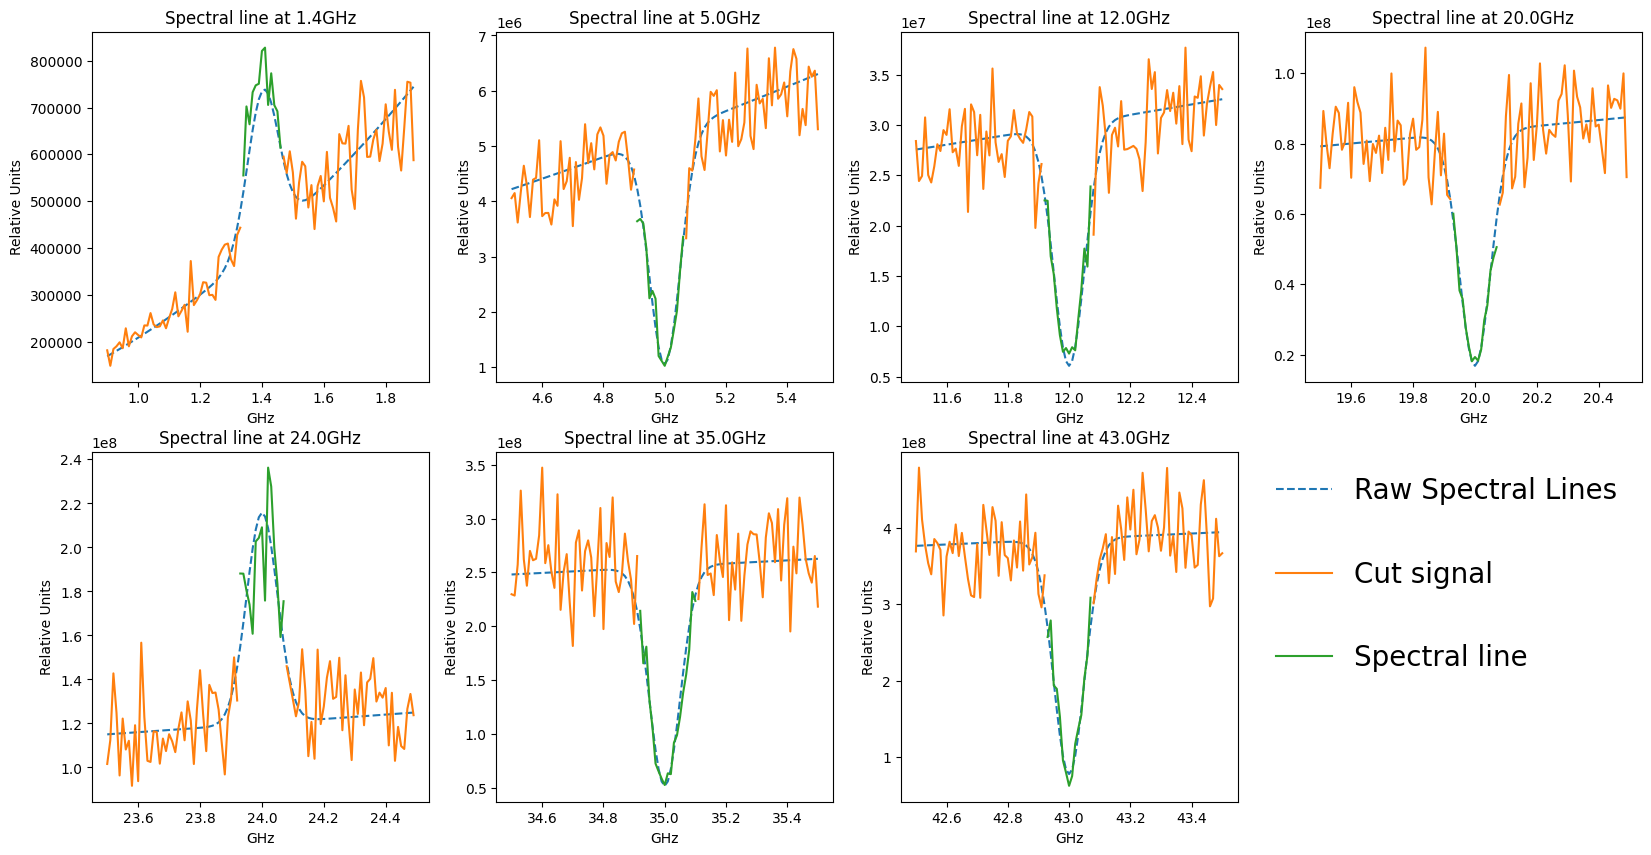

In [94]:
def integrate(x,y,start,end):
    area = 0
    x_part = x[start:end]
    y_part = y[start:end]
    # print(x_part)
    for i in range(len(x_part)-1):
        dx = x_part.iat[i+1]-x_part.iat[i]
        area+=dx*(y_part.iat[i+1]+y_part.iat[i])/2
    return area

fig, ax = plt.subplots(2,4,figsize = (20,10))
df_edit = [df[line]['cut'].copy() for line in range(len(spectral_lines))]
df_cut = [df[line][(df[line]['out'] == True)] for line in range(len(spectral_lines))]
start = [0 for line in range(len(spectral_lines))]
end = [0 for line in range(len(spectral_lines))]

for line in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]

    area = pd.DataFrame({'Area': pd.Series(dtype='float'),
                    'Start': pd.Series(dtype='int'),
                    'End': pd.Series(dtype='int')})
    
    start_temp = df_cut[line].index[0]
    end_temp = 0
        
    for i in range(1,len(df_cut[line].index)): 
        j = df_cut[line].index[i] 
        # print(i)
        # print(j)
        if start_temp==df_cut[line].index[i-1] and j - start_temp > 1:
            start_temp = j
        else:
            if j  - df_cut[line].index[i-1] > 1 or j == df_cut[line].index[-1]: 
                end_temp = df_cut[line].index[i-1]
                # print(df_cut[line]['X'])
                area.loc[len(area.index)] = [(integrate(df[line]['X'], df[line]['signal'], start_temp, end_temp)), start_temp, end_temp]
                if j != df_cut[line].index[-1]:
                    start_temp = j
        # print(start_temp, end_temp)

    area = area.sort_values("Area",ascending=False, ignore_index=True)
    area = area.astype({'Start': int, 'End': int})
    
    start[line] = area['Start'][0]
    end[line] = area['End'][0]
    
    df_edit[line] = df[line][['X','signal']].copy()
    df_edit[line]['signal'][start[line]:end[line]] = np.nan 
    
    axis = ax[line//4, line%4]
    axis.plot(df[line]['X'], spectral[points[0]:points[-1]+1], '--', label="Raw Spectral Lines")
    axis.plot(df[line]['X'], df_edit[line]['signal'], label="Cut signal")
    axis.plot(df[line]['X'][start[line]:end[line]], df[line]['signal'][start[line]:end[line]], label="Spectral line")

    axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

handles, labels = axis.get_legend_handles_labels()
ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis("off")
plt.show()

### 2.3 Applying threshold method on smooth signal

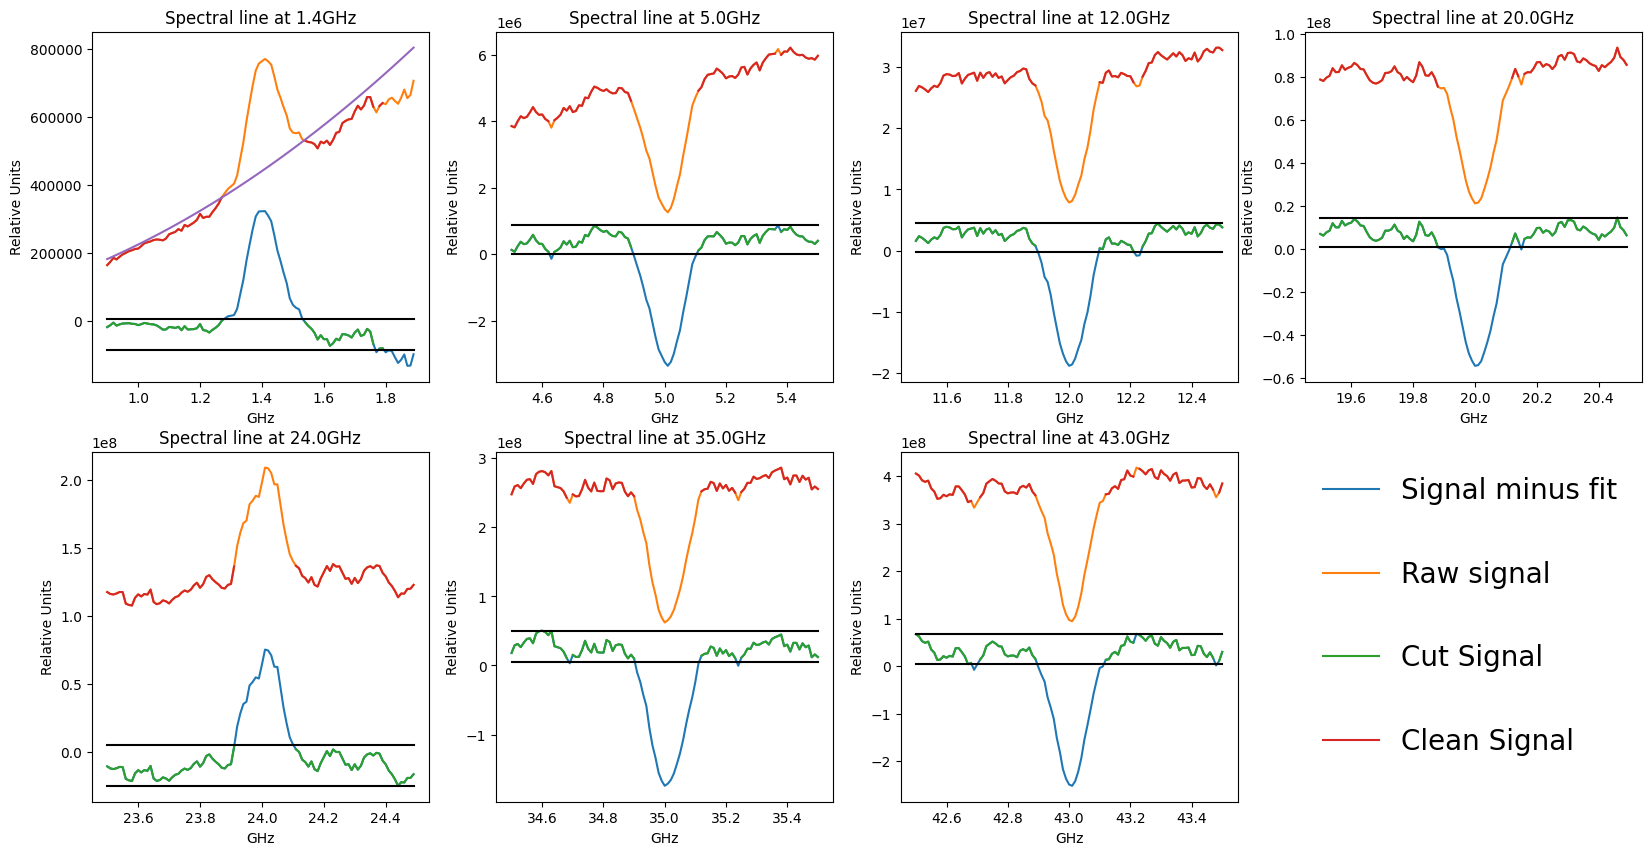

In [95]:
from scipy.stats import norm
from scipy import optimize
import pandas as pd

def quadratic(x, a):
    return a*x**2

pd.options.mode.chained_assignment = None  # default='warn'
# spectral_lines = np.array([1.4, 5, 12, 20, 24, 35, 43])S

# Trick for now
signal = clean + noise*clean

fig, ax = plt.subplots(2,4,figsize = (20,10))

df = 0
df = [pd.DataFrame({}) for i in range(len(spectral_lines))]

for line in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    # quad = False
    # if(signal[points[0]]<signal[points[-1]]):
    quad = True
    
    df[line]['X'] = np.array([X[j] for j in points])
    df[line]['signal'] = signal[points[0]:points[-1]+1]
    median = [np.nanmean(signal[point-3:point+3]) for point in points]
    df[line]['median'] = np.array(median)
    step = int(len(points)/10)

    popt, pcov = optimize.curve_fit(Bv, df[line]['X'], df[line]['median'])
    if(quad):
        popt1, pcov1 = optimize.curve_fit(quadratic, df[line]['X'], df[line]['median'])

    df[line]['cut'] = df[line]['median'] - Bv(df[line]['X'], *popt)
    flag = False

    h= np.histogram(df[line]['cut'])
    new_h = list()
    bin = h[1][0]-h[1][1]

    for j, c in enumerate(h[0]):
        if(c >= 15):
            new_h.append(h[1][j])
            last = j

    new_h.append(max(new_h)-bin)
    new_h = np.sort(new_h)

    df[line]['minus'] = df[line]['cut'] 
    df[line]['out'] = [False for i in df[line]['X']] 

    for j, y in enumerate(df[line]['cut']):
        if(y > new_h[-1]):
            df[line]['cut'][j] = np.nan
            df[line]['out'][j] = True
        if(y < new_h[0]):
            df[line]['cut'][j] = np.nan
            df[line]['out'][j] = True

    df[line]['clean'] = df[line]['cut'] + Bv(df[line]['X'], *popt)

    axis = ax[line//4, line%4]

    axis.plot(df[line]['X'], df[line]['minus'], label="Signal minus fit")
    axis.plot(df[line]['X'], df[line]['median'], label="Raw signal")
    axis.plot(df[line]['X'], df[line]['cut'], label="Cut Signal")
    axis.plot(df[line]['X'], df[line]['clean'], label="Clean Signal")
    axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[0], color='#000000')
    axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[-1], color='#000000')
    # axis.plot(X[points[start]:points[stop]], signal[points[start]:points[stop]], label ="Spectral Lines")
    # clean[points[0]:points[-1]+1] = df[line]['clean'].values
    # axis.plot(df[line]['X'], clean[points[0]:points[-1]+1])
    if(line == 0):
        axis.plot(df[line]['X'], Bv(df[line]['X'], *popt), label = "Blackbody fit")
    # if(quad):
    #     axis.plot(X_cords, quadratic(X_cords, *popt1), "--", label = "Quadratic fit")
    #     handles, labels = axis.get_legend_handles_labels()
    # axis.plot(X_cords, clean[points[0]:points[-1]+1], label='clean')
    axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

handles, labels = axis.get_legend_handles_labels()
ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()

### 2.4 Finding spectral lines by using smooth signal

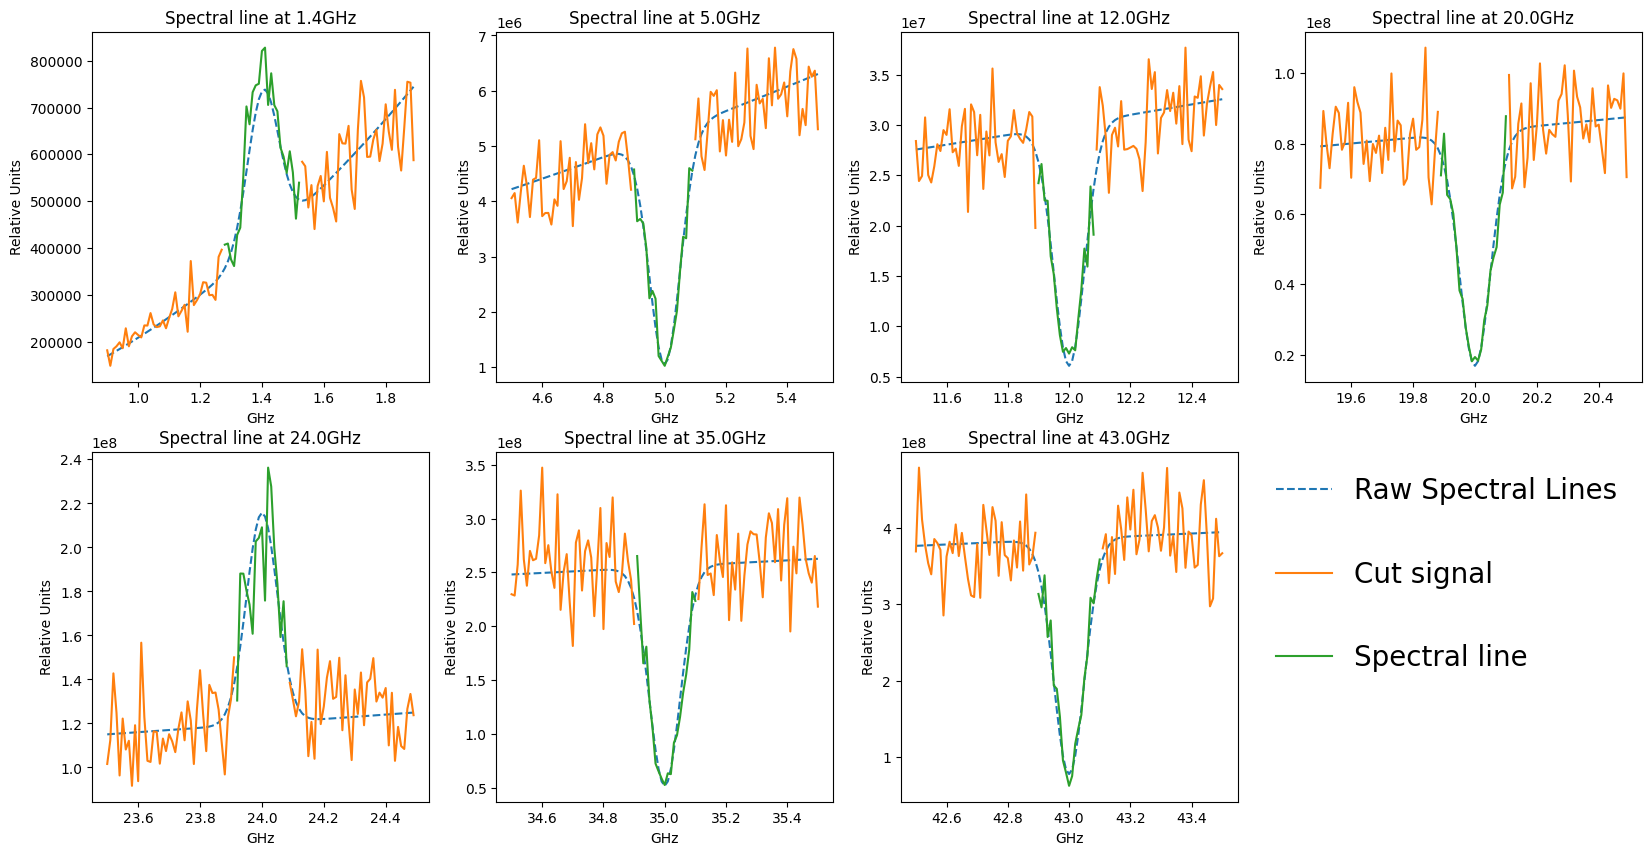

In [96]:
def integrate(x,y,start,end):
    area = 0
    x_part = x[start:end]
    y_part = y[start:end]
    # print(x_part)
    for i in range(len(x_part)-1):
        dx = x_part.iat[i+1]-x_part.iat[i]
        area+=dx*(y_part.iat[i+1]+y_part.iat[i])/2
    return area

fig, ax = plt.subplots(2,4,figsize = (20,10))
df_edit = [df[line]['cut'].copy() for line in range(len(spectral_lines))]
df_cut = [df[line][(df[line]['out'] == True)] for line in range(len(spectral_lines))]
start = [0 for line in range(len(spectral_lines))]
end = [0 for line in range(len(spectral_lines))]

for line in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]

    area = pd.DataFrame({'Area': pd.Series(dtype='float'),
                    'Start': pd.Series(dtype='int'),
                    'End': pd.Series(dtype='int')})
    
    start_temp = df_cut[line].index[0]
    end_temp = 0
        
    for i in range(1,len(df_cut[line].index)): 
        j = df_cut[line].index[i] 
        # print(i)
        # print(j)
        if start_temp==df_cut[line].index[i-1] and j - start_temp > 1:
            start_temp = j
        else:
            if j  - df_cut[line].index[i-1] > 1 or j == df_cut[line].index[-1]: 
                end_temp = df_cut[line].index[i-1]
                # print(df_cut[line]['X'])
                area.loc[len(area.index)] = [(integrate(df[line]['X'], df[line]['median'], start_temp, end_temp)), start_temp, end_temp]
                if j != df_cut[line].index[-1]:
                    start_temp = j
        # print(start_temp, end_temp)

    area = area.sort_values("Area",ascending=False, ignore_index=True)
    area = area.astype({'Start': int, 'End': int})
    
    start[line] = area['Start'][0]
    end[line] = area['End'][0]
    
    df_edit[line] = df[line][['X','signal']].copy()
    df_edit[line]['signal'][start[line]:end[line]] = np.nan 
    
    axis = ax[line//4, line%4]
    axis.plot(df[line]['X'], spectral[points[0]:points[-1]+1], '--', label="Raw Spectral Lines")
    axis.plot(df[line]['X'], df_edit[line]['signal'], label="Cut signal")
    axis.plot(df[line]['X'][start[line]:end[line]], df[line]['signal'][start[line]:end[line]], label="Spectral line")

    axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

handles, labels = axis.get_legend_handles_labels()
ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis("off")
plt.show()

### 2.5 Removing spectral lines and fitting signal

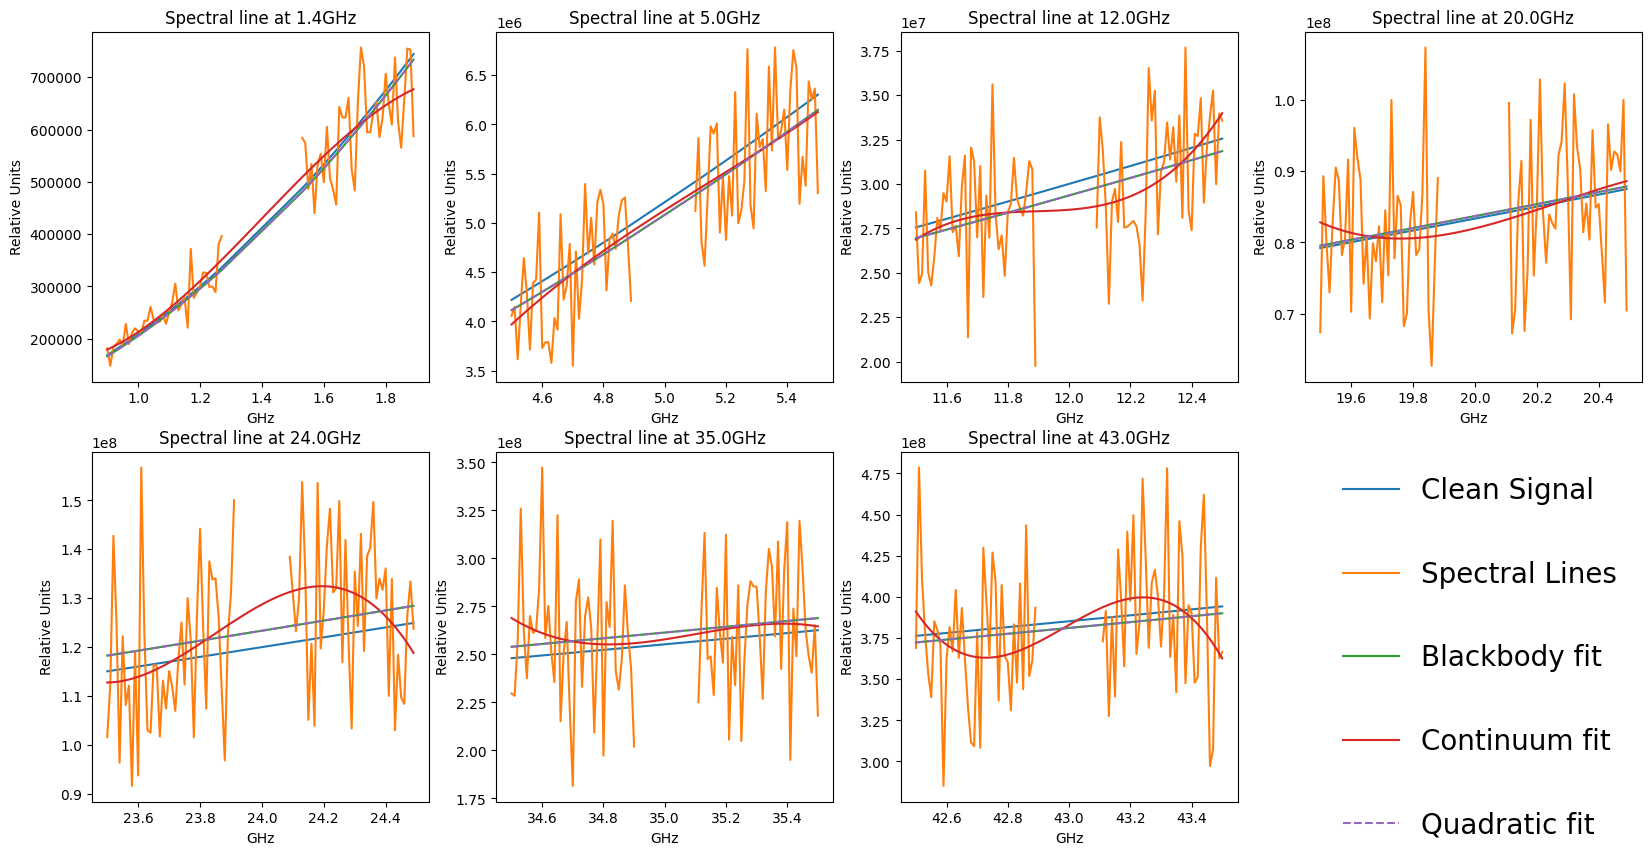

In [97]:
from scipy import optimize
import astropy.units as u
from specutils import Spectrum1D
from specutils.fitting import fit_continuum

def quadratic(x, a):
    return a*x**2

fig, ax = plt.subplots(2,4,figsize = (20,10))

for line in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    # quad = False
    # if(clean[points[0]]<clean[points[-1]]):
    quad = True

    units = u.erg / (u.cm ** 2 * u.s * u.Hz * u.sr)
    spectrum = Spectrum1D(flux=df[line]['signal'].to_numpy()*u.dimensionless_unscaled, spectral_axis=df[line]['X'].to_numpy()*u.AA)

    df_edit[line] = df_edit[line].dropna(axis=0, how='any')
    df[line]['clean'] = df[line]['signal']
    df[line]['clean'][start[line]:end[line]] = np.nan

    region = [(df[line]['X'][0]*u.AA, df[line]['X'][start[line]]*u.AA), (df[line]['X'][end[line]]*u.AA, df[line]['X'].iloc[-1]*u.AA)]
    fitted_continuum = fit_continuum(spectrum, window=region)
    df[line]['fit'] = fitted_continuum(df[line]['X'].to_numpy()*u.AA)

    popt, pcov = optimize.curve_fit(Bv, df_edit[line]['X'], df_edit[line]['signal'])
    popt1, pcov1 = optimize.curve_fit(quadratic, df_edit[line]['X'], df_edit[line]['signal'])

    axis = ax[line//4, line%4]

    axis.plot(df_edit[line]['X'], Bv(df_edit[line]['X'], T), label="Clean Signal")
    axis.plot(df[line]['X'], df[line]['clean'], label="Spectral Lines")
    axis.plot(df_edit[line]['X'], Bv(df_edit[line]['X'], *popt), label = "Blackbody fit")
    axis.plot(df[line]['X'], df[line]['fit'], label="Continuum fit")
    if(quad):
        axis.plot(df_edit[line]['X'], quadratic(df_edit[line]['X'], *popt1), '--', label = "Quadratic fit")
        handles, labels = axis.get_legend_handles_labels()
    axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()

#### Closer look of fits

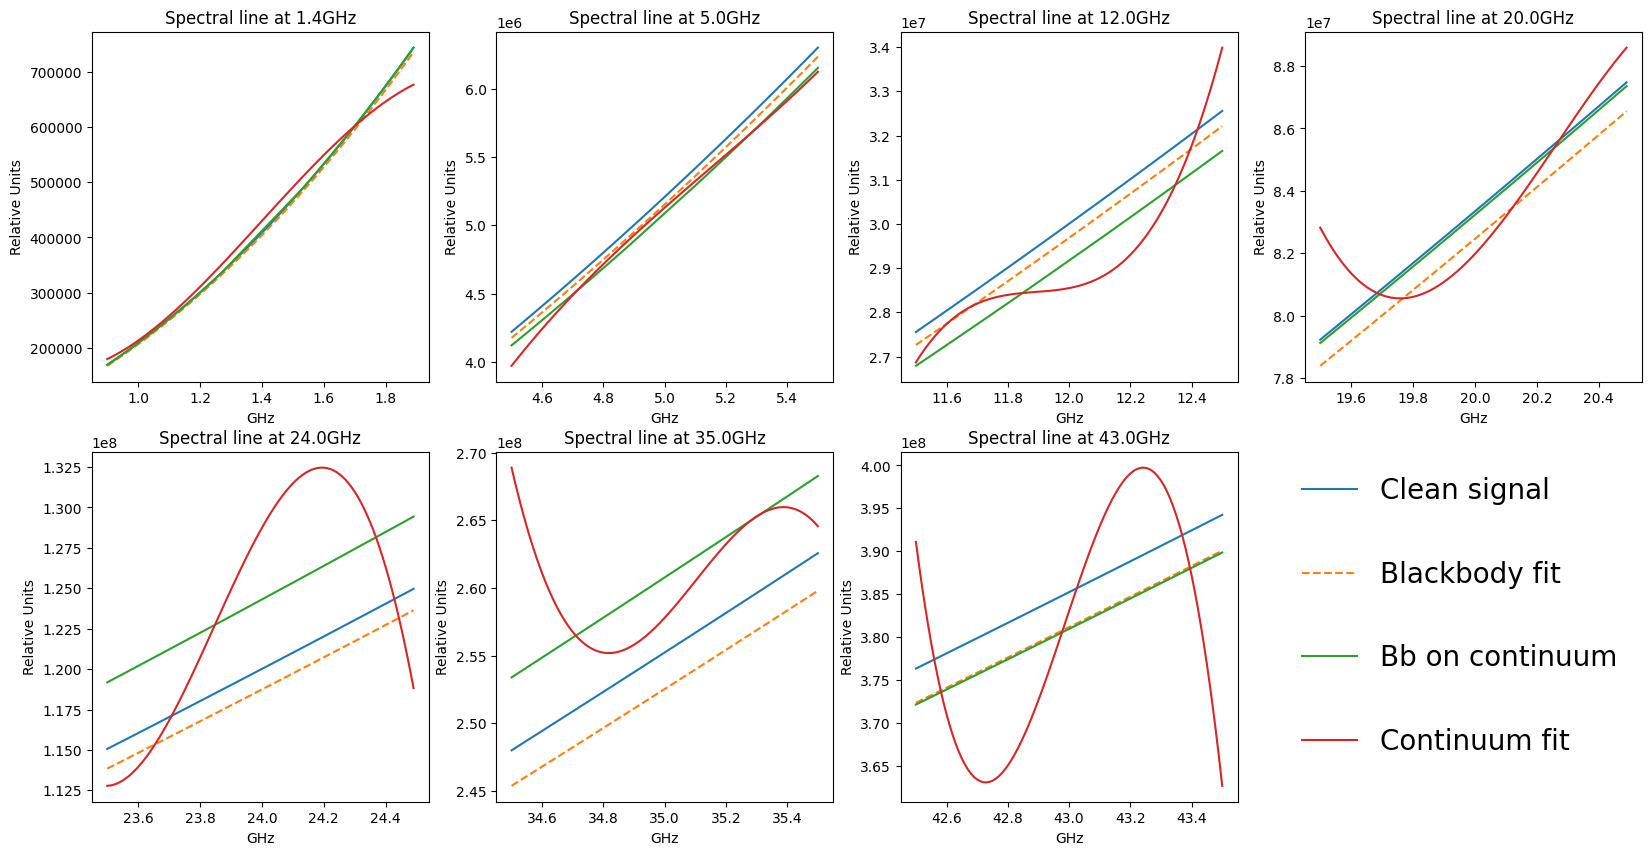

In [98]:
from scipy import optimize

def quadratic(x, a):
    return a*x**2

fig, ax = plt.subplots(2,4,figsize = (20,10))

for line in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    # quad = False
    # if(clean[points[0]]<clean[points[-1]]):
    quad = True

    popt_fit, pcov_fit = optimize.curve_fit(Bv, df[line]['X'], df[line]['fit'])
    
    axis = ax[line//4, line%4]

    axis.plot(df[line]['X'], Bv(df[line]['X'], T), label="Clean signal")
    # axis.plot(df[line]['X'], df[line]['clean'], label="Spectral Lines")
    axis.plot(df[line]['X'], Bv(df[line]['X'], *popt), "--", label="Blackbody fit")
    axis.plot(df_edit[line]['X'], Bv(df_edit[line]['X'], *popt_fit), label = "Bb on continuum")
    axis.plot(df[line]['X'], df[line]['fit'], label="Continuum fit")
    
    handles, labels = axis.get_legend_handles_labels()
    axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()

### 2.6 Calculating error of fittings

In [99]:
per_Bv = 0
per_Bv_raw = 0
per_Bv_spectral = 0
per_Bv_fit = 0
per_quad = 0
per_quad_raw = 0
per_quad_spectral = 0
per_quad_fit = 0

max_Bv = 0
max_Bv_raw = 0
max_Bv_spectral = 0
max_Bv_fit = 0
max_quad = 0
max_quad_raw = 0
max_quad_spectral = 0
max_quad_fit = 0

for line in range(len(spectral_lines)):
    quad = True
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    X_cords = np.array([X[j] for j in points])

    popt_Bv, pcov_Bv = optimize.curve_fit(Bv, df_edit[line]['X'], df_edit[line]['signal'])
    popt_Bv_spectral, pcov_Bv_spectral = optimize.curve_fit(Bv, X_cords, signal[points[0]: points[-1]+1])
    popt_Bv_raw, pcov_Bv_raw = optimize.curve_fit(Bv, X_cords, raw[points[0]:points[-1]+1])
    popt_Bv_fit, pcov_Bv_fit = optimize.curve_fit(Bv, df[line]['X'], df[line]['fit']) #specutils
    
    T_Bv_raw = popt_Bv_raw[0]
    if(np.abs(T-T_Bv_raw) > max_Bv_raw):
        max_Bv_raw = T_Bv_raw
    per_Bv_raw = max(np.abs(T-T_Bv_raw)/T *100, per_Bv_raw)
    T_Bv_spectral = popt_Bv_spectral[0]
    if(np.abs(T-T_Bv_spectral) > max_Bv_spectral):
        max_Bv_spectral = T_Bv_spectral
    per_Bv_spectral = max(np.abs(T-T_Bv_spectral)/T *100, per_Bv_spectral)
    T_Bv = popt_Bv[0]
    if(np.abs(T-T_Bv) > max_Bv):
        max_Bv = T_Bv
    per_Bv = max(np.abs(T-T_Bv)/T *100, per_Bv)
    T_Bv_fit = popt_Bv_fit[0]
    if(np.abs(T-T_Bv_fit) > max_Bv_fit):
        max_Bv_fit = T_Bv_fit
    per_Bv_fit = max(np.abs(T-T_Bv_fit)/T *100, per_Bv_fit)

    if(quad):
        popt_quad, pcov_quad = optimize.curve_fit(quadratic, df_edit[line]['X'], df_edit[line]['signal'])
        popt_quad_spectral, pcov_quad_spectral = optimize.curve_fit(quadratic, X_cords, signal[points[0]: points[-1]+1])
        popt_quad_raw, pcov_quad_raw = optimize.curve_fit(quadratic, X_cords, raw[points[0]:points[-1]+1])
        popt_quad_fit, pcov_quad_fit = optimize.curve_fit(quadratic, df[line]['X'], df[line]['fit']) #specutils
        
        power = 6.62607015/1.380649 *10**(-2)

        T_quad_raw = popt_quad_raw[0]*power
        if(np.abs(T-T_quad_raw) > max_quad_raw):
            max_quad_raw = T_quad_raw
        per_quad_raw = max(np.abs(T-T_quad_raw)/T *100, per_quad_raw)
        T_quad_spectral = popt_quad_spectral[0]*power
        if(np.abs(T-T_quad_spectral) > max_quad_spectral):
            max_quad_spectral = T_quad_spectral
        per_quad_spectral = max(np.abs(T-T_quad_spectral)/T *100, per_quad_spectral)
        T_quad = popt_quad[0]*power
        if(np.abs(T-T_quad) > max_quad):
            max_quad = T_quad
        per_quad = max(np.abs(T-T_quad)/T *100, per_quad)
        T_quad_fit = popt_quad_fit[0]*power
        if(np.abs(T-T_quad_fit) > max_quad_fit):
            max_quad_fit = T_quad_fit
        per_quad_fit = max(np.abs(T-T_quad_fit)/T *100, per_quad_fit)
        
print("Fitting with Blackbody")
print("Real temperature value:", T,"K")
print("Without Spectral Lines:", max_Bv_raw,"K", round(per_Bv_raw,2), "%")
print("With Spectral Lines:   ", max_Bv_spectral,"K", round(per_Bv_spectral,2),"%")
print("Filtered Signal:       ", max_Bv,"K", round(per_Bv,2),"%")
print("Specutils filter:      ", max_Bv_fit,"K", round(per_Bv_fit,2),"%")

print("Fitting with Quadratic")
print("Without Spectral Lines:", max_quad_raw,"K", round(per_quad_raw,2), "%")
print("With Spectral Lines:   ", max_quad_spectral,"K", round(per_quad_spectral,2),"%")
print("Filtered Signal:       ", max_quad,"K", round(per_quad,2),"%")
print("Specutils filter:      ", max_quad_fit,"K", round(per_quad_fit,2),"%")

Fitting with Blackbody
Real temperature value: 10000.0 K
Without Spectral Lines: 9957.84138947577 K 1.22 %
With Spectral Lines:    10839.64569865807 K 11.5 %
Filtered Signal:        9859.591688341503 K 2.8 %
Specutils filter:       9998.583462934104 K 3.58 %
Fitting with Quadratic
Without Spectral Lines: 9957.826906683118 K 1.21 %
With Spectral Lines:    10839.860563590222 K 11.49 %
Filtered Signal:        9859.56582399988 K 2.79 %
Specutils filter:       9998.554807804294 K 3.57 %


## 3. Choosing variables to apply Slope Method

In [100]:
percent = 8
bins = 20
divisor = 10

### 3.1 Applying Slope Method

We decided to implement a method that utilizes the slopes of a signal
on our final data because it yielded the best results and is less susceptible
to errors. This method detects a spectral line by identifying points in the
signal with steeper slopes compared to the rest, whether positive or negative.

Depending on the sampling rate, the slope between consecutive points may
be very small. To facilitate effective point comparison, we calculate the slope
relative to the number of points, for example a slope can calculated from two
points that are ten points aparts.

Subsequently, we determine which values are more frequent with the
assistance of a histogram and establish a range of median values just like the
previous method.

With the help of the specified range, we find the two biggest areas outside
the median values, and when their outer points are combined, they represent
the spectral line.
9

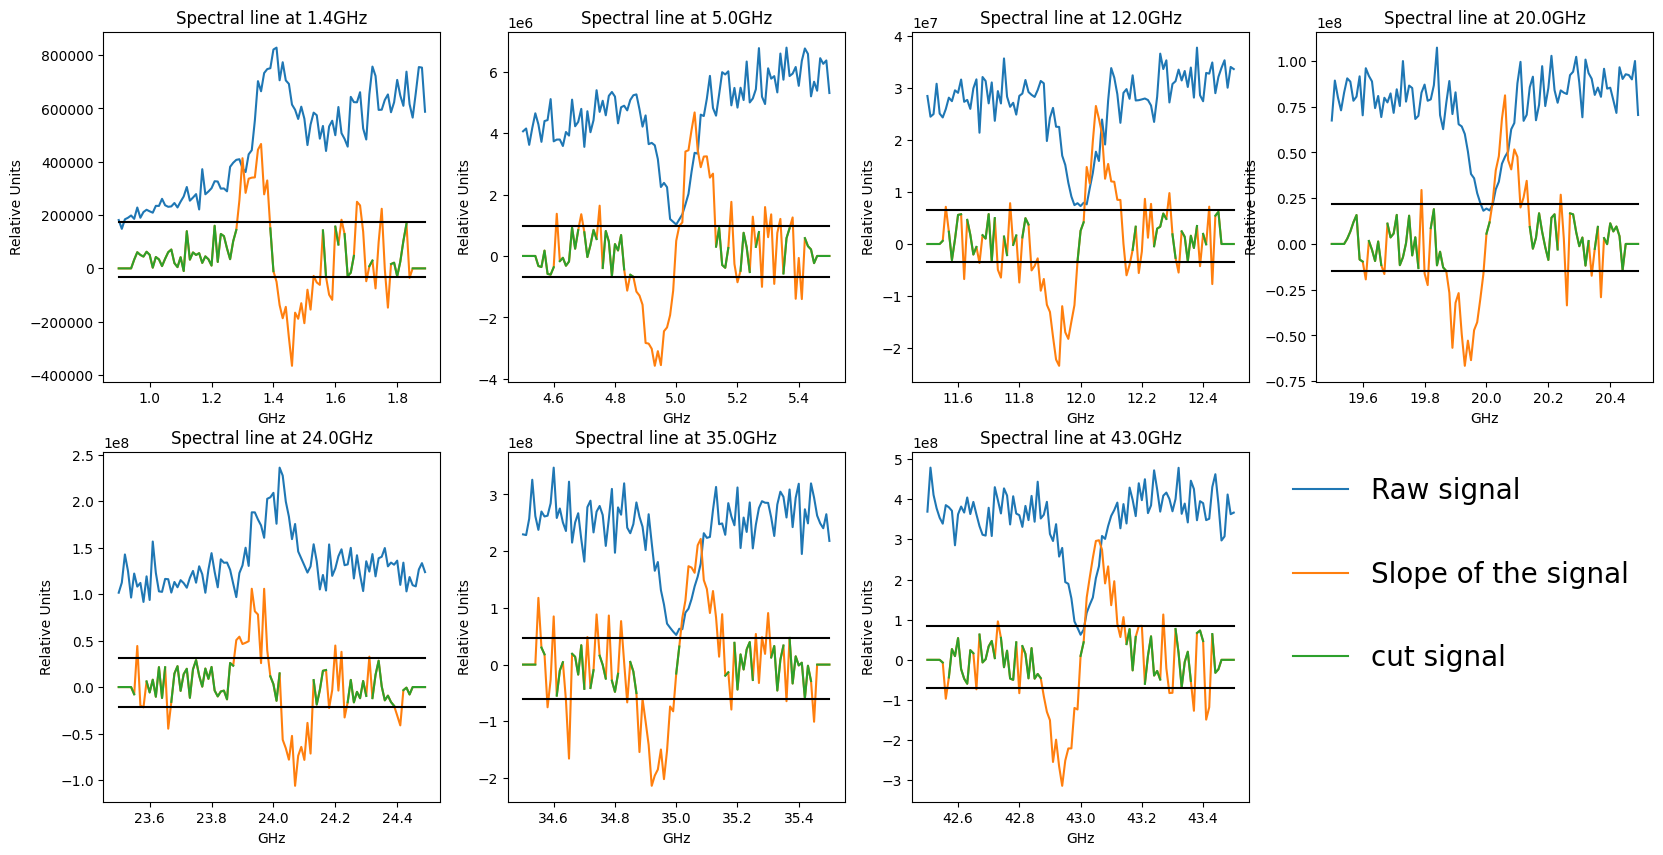

In [101]:
def quadratic(x, a):
    return a*x**2

# X0 = 100
# X = np.geomspace(10e-3 , X0, 50000)
# clean = Bv(X, T)
# lines = clean

# spectral_lines = np.array([1.4, 5, 12, 20, 24, 35, 43])

# Trick for now
# noise = np.random.normal(0,0.3,len(clean))
# signal = clean + noise*clean

fig, ax = plt.subplots(2,4,figsize = (20,10))

df = 0
df = [pd.DataFrame({}) for line in range(len(spectral_lines))]

for line in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    # quad = False
    # if(signal[points[0]]<signal[points[-1]]):
    quad = True

    df[line]['X'] = np.array([X[j] for j in points])
    df[line]['signal'] = signal[points[0]:points[-1]+1]

    step = int(len(points)/divisor)

    df_edit[line] = df[line]
    df[line]['slope'] = df[line]['signal'].diff(step).shift(periods = -int(np.ceil(step/2)), fill_value=0).fillna(value = 0)

    h= np.histogram(df[line]['slope'], bins=bins)
    new_h = list()
    bin = h[1][0]-h[1][1]

    for j, c in enumerate(h[0]):
        if(c >= df[line]['slope'].size*percent/100):
            new_h.append(h[1][j])
            last = j

    new_h.append(max(new_h)-bin)
    new_h = np.sort(new_h)

    #με υπολογισμο εμβαδου βρισκω τα διαστηματα στο μελλον
    df[line]['cut'] = df[line]['slope']
    df[line]['top'] = [False for i in df[line]['X']] 
    df[line]['bot'] = [False for i in df[line]['X']]
    
    for j, y in enumerate(df[line]['cut']):
        if(y > new_h[-1]):
            df[line]['cut'][j] = np.nan
            df[line]['top'][j] = True
        if(y < new_h[0]):
            df[line]['cut'][j] = np.nan
            df[line]['bot'][j] = True

    axis = ax[line//4, line%4]
    axis.plot(df[line]['X'], df[line]['signal'], label="Raw signal")
    axis.plot(df[line]['X'], df[line]['slope'], label="Slope of the signal")
    axis.plot(df[line]['X'], df[line]['cut'], label="cut signal")
    axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[0], color='#000000')
    axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[-1], color='#000000')
    
    axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

handles, labels = axis.get_legend_handles_labels()
ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()

### 3.2 Finding spectral lines

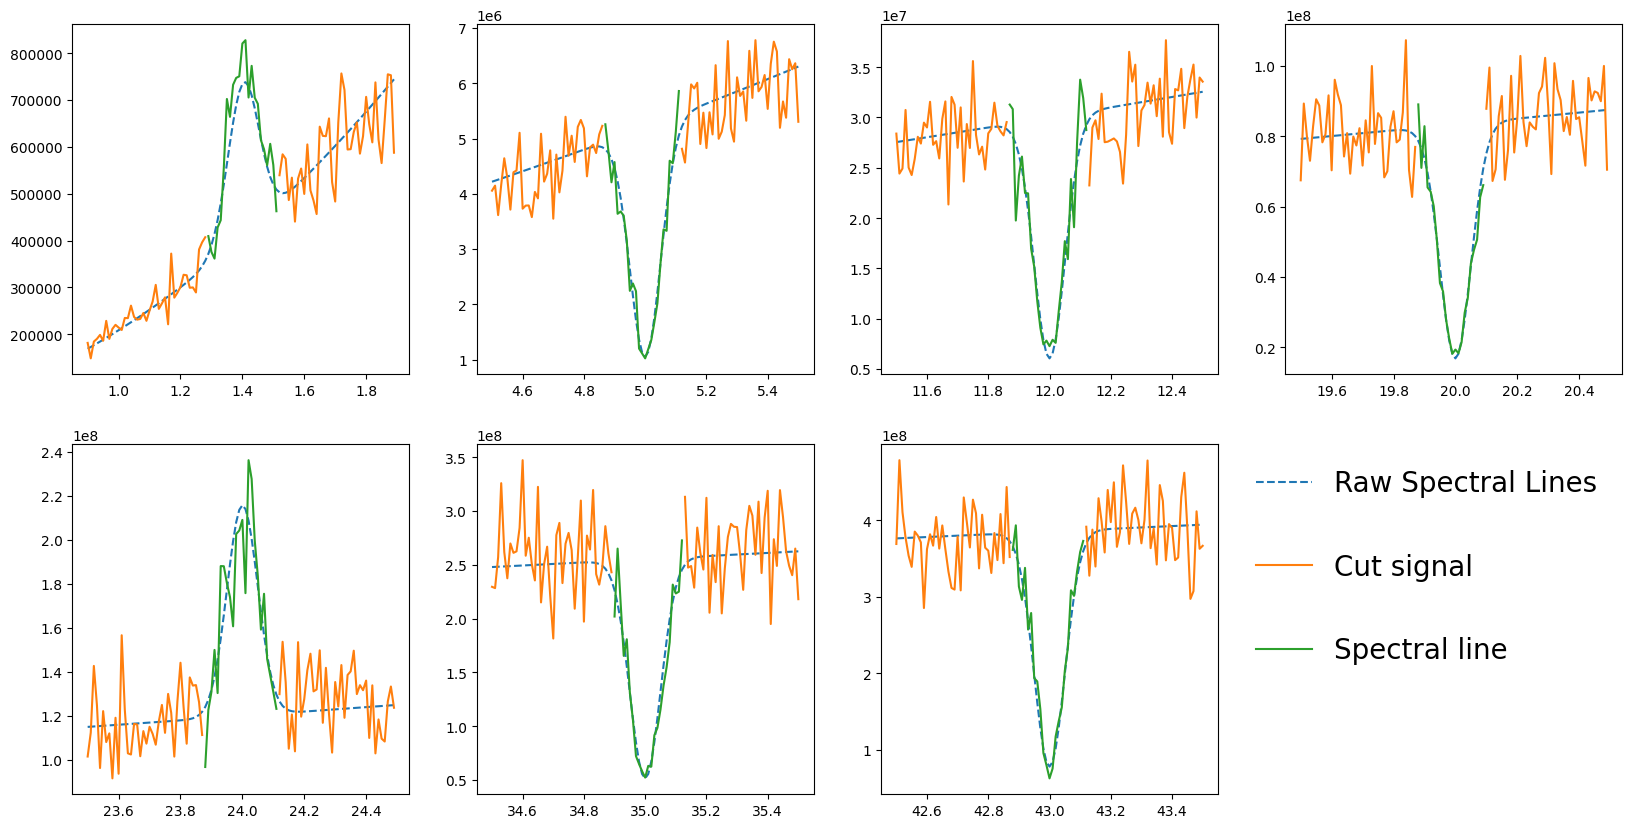

In [102]:
def integrate(x,y,start,end):
    area = 0
    x_part = x[start:end]
    y_part = y[start:end]
    # print(x_part)
    for i in range(len(x_part)-1):
        dx = x_part.iat[i+1]-x_part.iat[i]
        area+=dx*(y_part.iat[i+1]+y_part.iat[i])/2
    return area

fig, ax = plt.subplots(2,4,figsize = (20,10))
df_edit = [df[line]['cut'].copy() for line in range(len(spectral_lines))]
df_top = df.copy()
df_bot = df.copy()
start = [0 for line in range(len(spectral_lines))]
end = [0 for line in range(len(spectral_lines))]

for line in range(len(spectral_lines)):
    df_top[line] = df[line][(df[line]['top'] == True)]
    df_bot[line] = df[line][(df[line]['bot'] == True)]
    
    start_top = df_top[line].index[0]
    start_bot = df_bot[line].index[0]
    end_top = 0
    end_bot = 0

    area_top = pd.DataFrame({'Area': pd.Series(dtype='float'),
                    'Start': pd.Series(dtype='int'),
                    'End': pd.Series(dtype='int')})
    area_bot = pd.DataFrame({'Area': pd.Series(dtype='float'),
                    'Start': pd.Series(dtype='int'),
                    'End': pd.Series(dtype='int')})

    for i in range(1,len(df_top[line].index)): 
        j = df_top[line].index[i]        
        # print(i)
        # print(j)
        if start_top==df_top[line].index[i-1] and j - start_top > 1:
            start_top = j
        else:
            if j  - df_top[line].index[i-1]> 1 or j == df_top[line].index[-1]: 
                end_top = df_top[line].index[i-1]
                area_top.loc[len(area_top.index)] = [(integrate(df[line]['X'], df[line]['signal'], start_top, end_top)), start_top, end_top]
                if j != df_top[line].index[-1]:
                    start_top = j
            # print(start_top, end_top)
            
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    
    for i in range(1,len(df_bot[line].index)): 
        j = df_bot[line].index[i] 
        # print(i)
        # print(j)
        if start_bot==df_bot[line].index[i-1] and j - start_bot > 1:
            start_bot = j
        else:
            if j  - df_bot[line].index[i-1] > 1 or j == df_bot[line].index[-1]: 
                end_bot = df_bot[line].index[i-1]
                area_bot.loc[len(area_bot.index)] = [(integrate(df[line]['X'], df[line]['signal'], start_bot, end_bot)), start_bot, end_bot]
                if j != df_bot[line].index[-1]:
                    start_bot = j
            # print(start_bot, end_bot)
    
    
    area_top = area_top.sort_values("Area",ascending=False, ignore_index=True)
    area_bot = area_bot.sort_values("Area",ascending=False, ignore_index=True)
    
    # print("Top: ")
    # print(area_top)
    # print("Bot: ")
    # print(area_bot)
    start_top = area_top['Start'][0]
    end_top = area_top['End'][0]
    start_bot = area_bot['Start'][0]
    end_bot = area_bot['End'][0]
    
    start[line] = int(min(start_top,start_bot))
    end[line] = int(max(end_top,end_bot))
    
    df_edit[line] = df[line][['X','signal']].copy()
    df_edit[line]['signal'][start[line]:end[line]] = np.nan
    
    axis = ax[line//4, line%4]
    axis.plot(df[line]['X'], spectral[points[0]:points[-1]+1], '--', label="Raw Spectral Lines")
    axis.plot(df[line]['X'], df_edit[line]['signal'], label="Cut signal")
    axis.plot(df[line]['X'][start[line]:end[line]], df[line]['signal'][start[line]:end[line]], label="Spectral line")
 
handles, labels = axis.get_legend_handles_labels()
ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()


### 3.3 Applying slope method on smooth signal

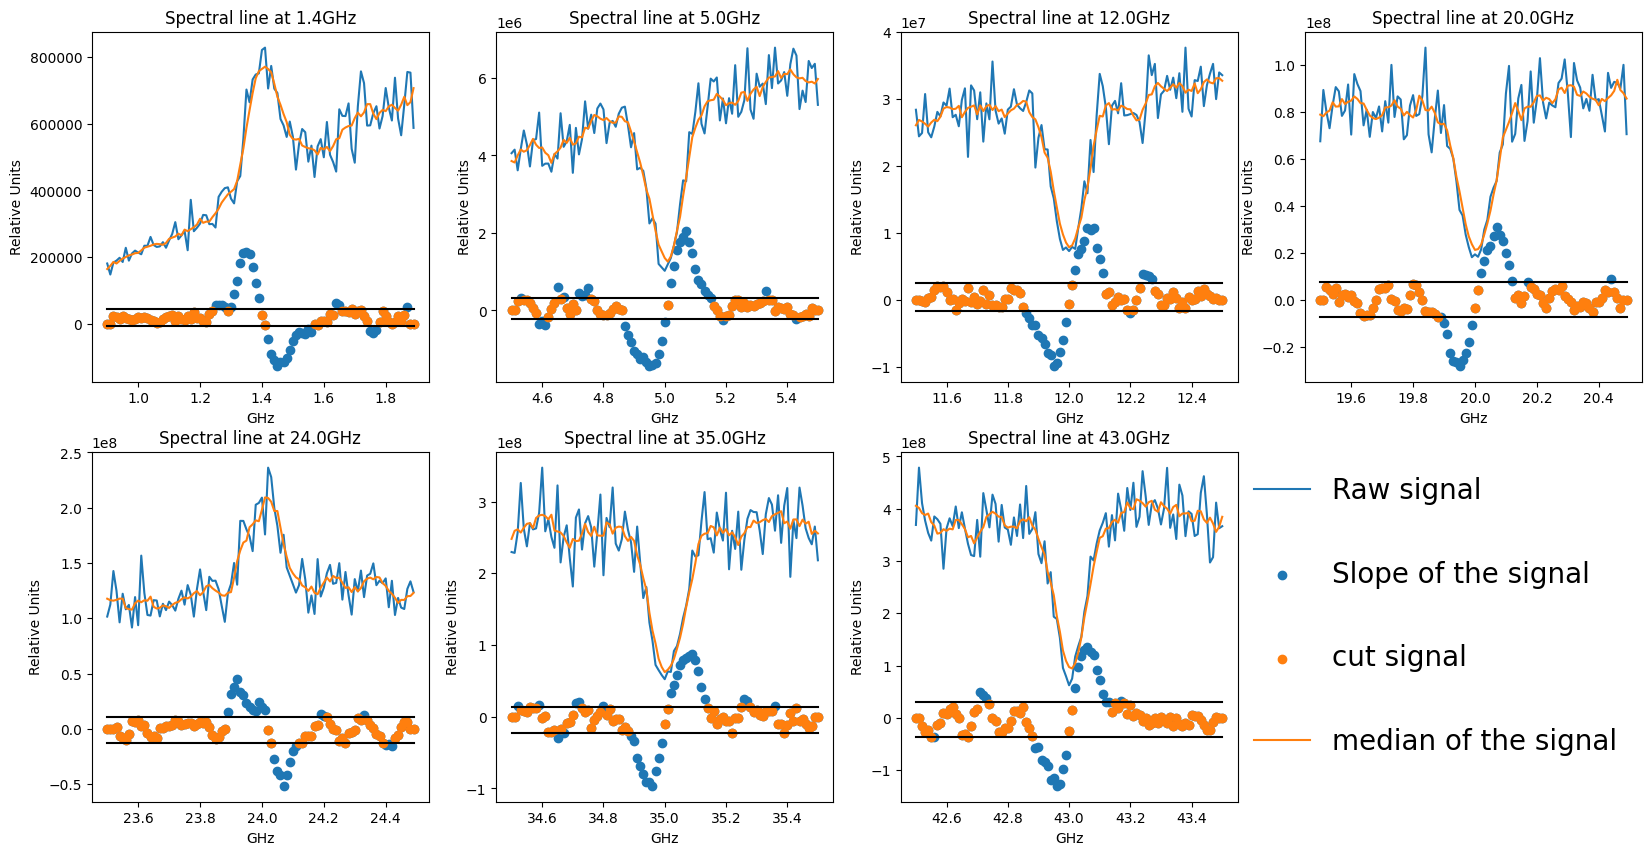

In [103]:
def quadratic(x, a):
    return a*x**2

# X0 = 100
# X = np.geomspace(10e-3 , X0, 50000)
# clean = Bv(X, T)
# lines = clean

# spectral_lines = np.array([1.4, 5, 12, 20, 24, 35, 43])

# Trick for now
# noise = np.random.normal(0,0.3,len(clean))

fig, ax = plt.subplots(2,4,figsize = (20,10))

# df = 0
# df = [pd.DataFrame({}) for line in range(len(spectral_lines))]

# for i in range(0, N):
#     			median_power[i] = np.nanmedian(median_power[i:i+20])

for line in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    # quad = False
    # if(signal[points[0]]<signal[points[-1]]):
    quad = True
    median = [np.nanmean(signal[point-3:point+3]) for point in points]
    df[line]['median'] = np.array(median)
    
    # step = int(len(points)/divisor)
    step = 4

    df_edit[line] = df[line]
    df[line]['slope'] = df[line]['median'].diff(step).shift(periods = -int(np.ceil(step/2)), fill_value=0).fillna(value = 0)

    h= np.histogram(df[line]['slope'], bins=bins)
    new_h = list()
    bin = h[1][0]-h[1][1]

    for j, c in enumerate(h[0]):
        if(c >= df[line]['slope'].size*percent/100):
            new_h.append(h[1][j])
            last = j

    new_h.append(max(new_h)-bin)
    new_h = np.sort(new_h)

    #με υπολογισμο εμβαδου βρισκω τα διαστηματα στο μελλον
    df[line]['cut'] = df[line]['slope']
    
    df[line]['top'] = [False for i in df[line]['X']] 
    df[line]['bot'] = [False for i in df[line]['X']]
    for j, y in enumerate(df[line]['cut']):
        if(y > new_h[-1]):
            df[line]['cut'][j] = np.nan
            df[line]['top'][j] = True
        if(y < new_h[0]):
            df[line]['cut'][j] = np.nan
            df[line]['bot'][j] = True
            

    axis = ax[line//4, line%4]
    axis.plot(df[line]['X'], df[line]['signal'], label="Raw signal")
    axis.scatter(df[line]['X'], df[line]['slope'], label="Slope of the signal")
    axis.scatter(df[line]['X'], df[line]['cut'], label="cut signal")
    axis.plot(df[line]['X'], df[line]['median'], label="median of the signal")
    axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[0], color='#000000')
    axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[-1], color='#000000')
    
    axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

handles, labels = axis.get_legend_handles_labels()
ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()

### 3.4 Finding spectral lines by using smooth signal

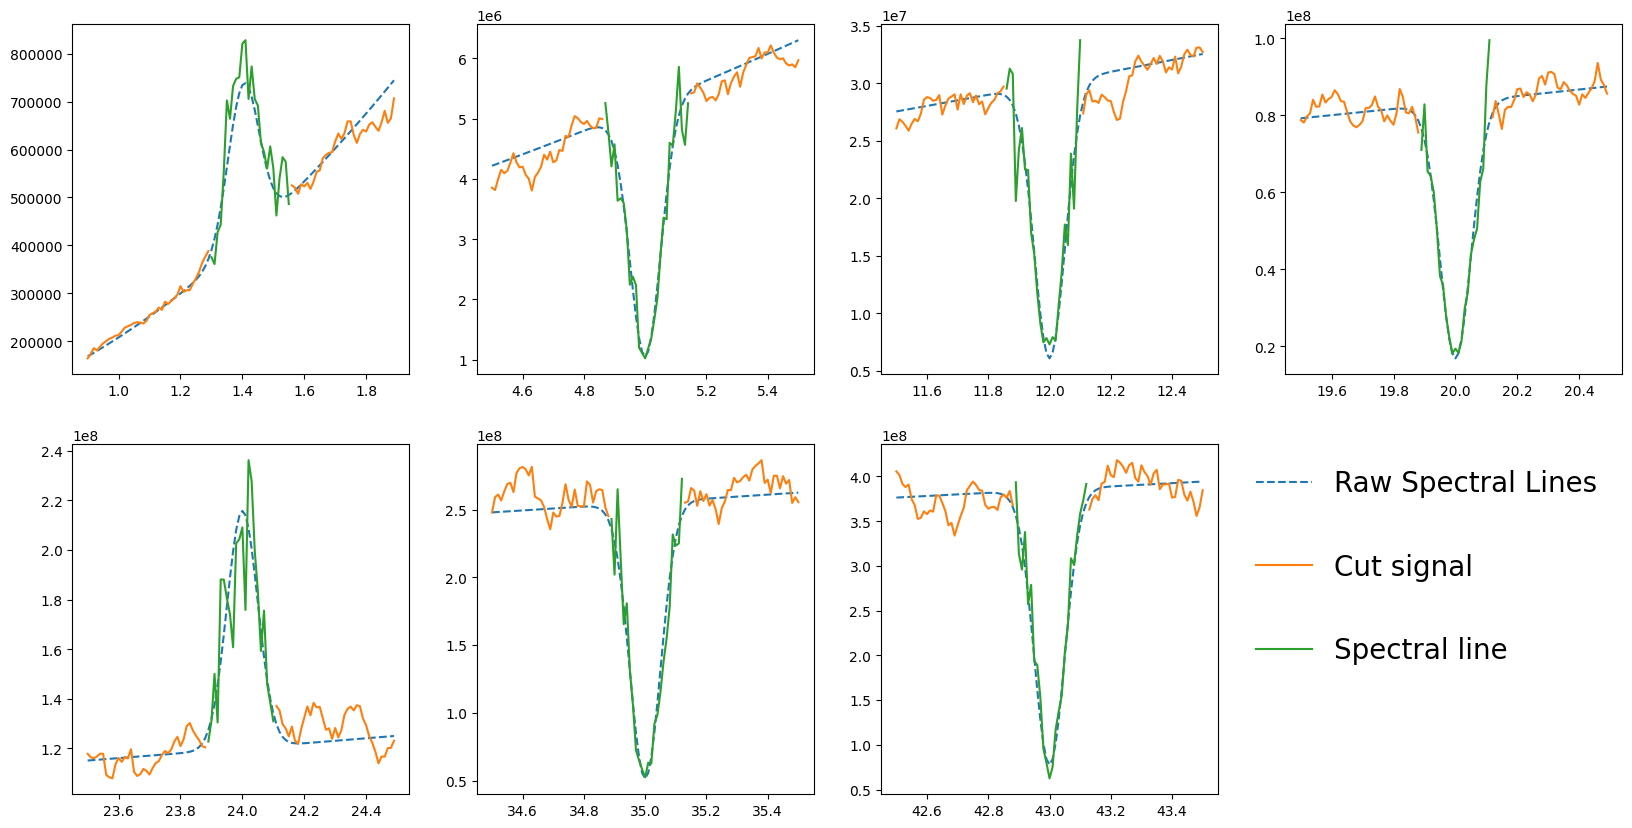

In [104]:
def integrate(x,y,start,end):
    area = 0
    x_part = x[start:end]
    y_part = y[start:end]
    # print(x_part)
    for i in range(len(x_part)-1):
        dx = x_part.iat[i+1]-x_part.iat[i]
        area+=dx*(y_part.iat[i+1]+y_part.iat[i])/2
    return area

fig, ax = plt.subplots(2,4,figsize = (20,10))
df_edit = [df[line]['cut'].copy() for line in range(len(spectral_lines))]
df_top = df.copy()
df_bot = df.copy()
start = [0 for line in range(len(spectral_lines))]
end = [0 for line in range(len(spectral_lines))]

for line in range(len(spectral_lines)):
    df_top[line] = df[line][(df[line]['top'] == True)]
    df_bot[line] = df[line][(df[line]['bot'] == True)]
    
    start_top = df_top[line].index[0]
    start_bot = df_bot[line].index[0]
    end_top = 0
    end_bot = 0

    area_top = pd.DataFrame({'Area': pd.Series(dtype='float'),
                    'Start': pd.Series(dtype='int'),
                    'End': pd.Series(dtype='int')})
    area_bot = pd.DataFrame({'Area': pd.Series(dtype='float'),
                    'Start': pd.Series(dtype='int'),
                    'End': pd.Series(dtype='int')})

    for i in range(1,len(df_top[line].index)): 
        j = df_top[line].index[i]        
        # print(i)
        # print(j)
        if start_top==df_top[line].index[i-1] and j - start_top > 1:
            start_top = j
        else:
            if j  - df_top[line].index[i-1]> 1 or j == df_top[line].index[-1]: 
                end_top = df_top[line].index[i-1]
                area_top.loc[len(area_top.index)] = [(integrate(df[line]['X'], df[line]['median'], start_top, end_top)), start_top, end_top]
                if j != df_top[line].index[-1]:
                    start_top = j
            # print(start_top, end_top)
            
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    
    for i in range(1,len(df_bot[line].index)): 
        j = df_bot[line].index[i] 
        # print(i)
        # print(j)
        if start_bot==df_bot[line].index[i-1] and j - start_bot > 1:
            start_bot = j
        else:
            if j  - df_bot[line].index[i-1] > 1 or j == df_bot[line].index[-1]: 
                end_bot = df_bot[line].index[i-1]
                area_bot.loc[len(area_bot.index)] = [(integrate(df[line]['X'], df[line]['median'], start_bot, end_bot)), start_bot, end_bot]
                if j != df_bot[line].index[-1]:
                    start_bot = j
            # print(start_bot, end_bot)
    
    
    area_top = area_top.sort_values("Area",ascending=False, ignore_index=True)
    area_bot = area_bot.sort_values("Area",ascending=False, ignore_index=True)
    
    # print("Top: ")
    # print(area_top)
    # print("Bot: ")
    # print(area_bot)
    start_top = area_top['Start'][0]
    end_top = area_top['End'][0]
    start_bot = area_bot['Start'][0]
    end_bot = area_bot['End'][0]
    
    start[line] = int(min(start_top,start_bot))
    end[line] = int(max(end_top,end_bot))
    
    df_edit[line] = df[line][['X','median']].copy()
    df_edit[line]['median'][start[line]:end[line]] = np.nan
    
    axis = ax[line//4, line%4]
    axis.plot(df[line]['X'], spectral[points[0]:points[-1]+1], '--', label="Raw Spectral Lines")
    axis.plot(df[line]['X'], df_edit[line]['median'], label="Cut signal")
    axis.plot(df[line]['X'][start[line]:end[line]], df[line]['signal'][start[line]:end[line]], label="Spectral line")
 
handles, labels = axis.get_legend_handles_labels()
ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()


### 3.5 Removing spectral lines and fitting signal

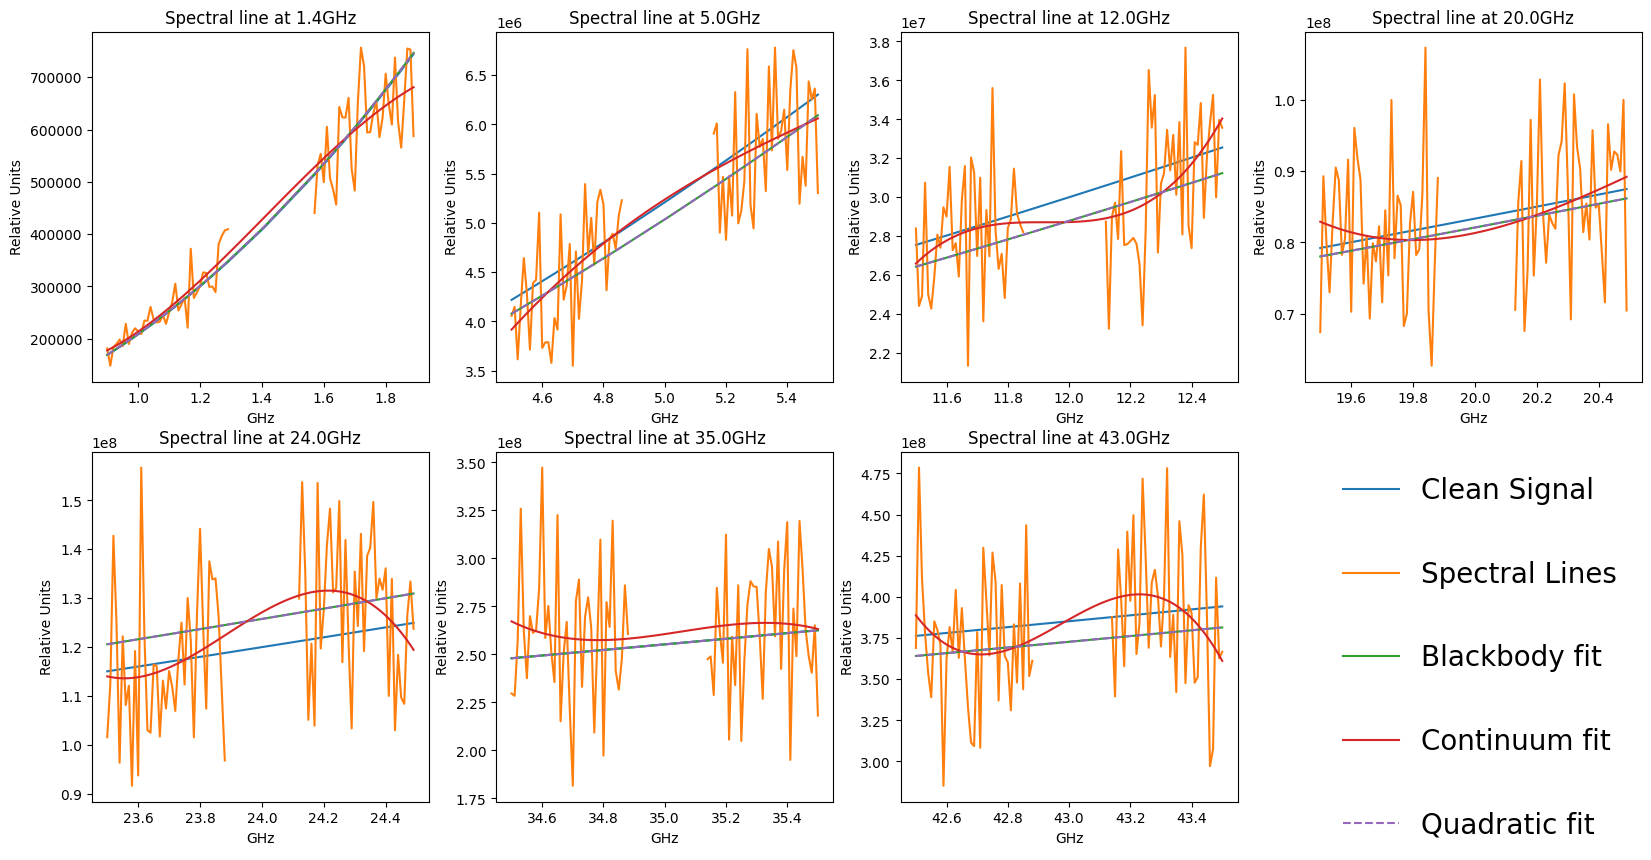

In [105]:
from scipy import optimize
import astropy.units as u
from specutils import Spectrum1D
from specutils.fitting import fit_continuum

def quadratic(x, a):
    return a*x**2

fig, ax = plt.subplots(2,4,figsize = (20,10))
df_edit = df.copy()
for line in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    # quad = False
    # if(clean[points[0]]<clean[points[-1]]):
    quad = True

    units = u.erg / (u.cm ** 2 * u.s * u.Hz * u.sr)
    spectrum = Spectrum1D(flux=df[line]['signal'].to_numpy()*u.dimensionless_unscaled, spectral_axis=df[line]['X'].to_numpy()*u.AA)

    df_edit[line] = df_edit[line].dropna(axis=0, how='any')
    df[line]['clean'] = df[line]['signal']
    df[line].loc[start[line]:end[line],'clean'] = np.nan

    region = [(df[line]['X'][0]*u.AA, df[line]['X'][start[line]]*u.AA), (df[line]['X'][end[line]]*u.AA, df[line]['X'].iloc[-1]*u.AA)]
    fitted_continuum = fit_continuum(spectrum, window=region)

    df[line]['fit'] = fitted_continuum(df[line]['X'].to_numpy()*u.AA)

    popt, pcov = optimize.curve_fit(Bv, df_edit[line]['X'], df_edit[line].loc[:,'signal'])
    popt1, pcov1 = optimize.curve_fit(quadratic, df_edit[line]['X'], df_edit[line]['signal'])
    
    axis = ax[line//4, line%4]

    axis.plot(df_edit[line]['X'], Bv(df_edit[line]['X'], T), label="Clean Signal")
    axis.plot(df[line]['X'], df[line]['clean'], label="Spectral Lines")
    axis.plot(df_edit[line]['X'], Bv(df_edit[line]['X'], *popt), label = "Blackbody fit")
    axis.plot(df[line]['X'], df[line]['fit'], label="Continuum fit")
    
    if(quad):
        axis.plot(df_edit[line]['X'], quadratic(df_edit[line]['X'], *popt1), '--', label = "Quadratic fit")
        handles, labels = axis.get_legend_handles_labels()
    axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()

#### Closer look of fits

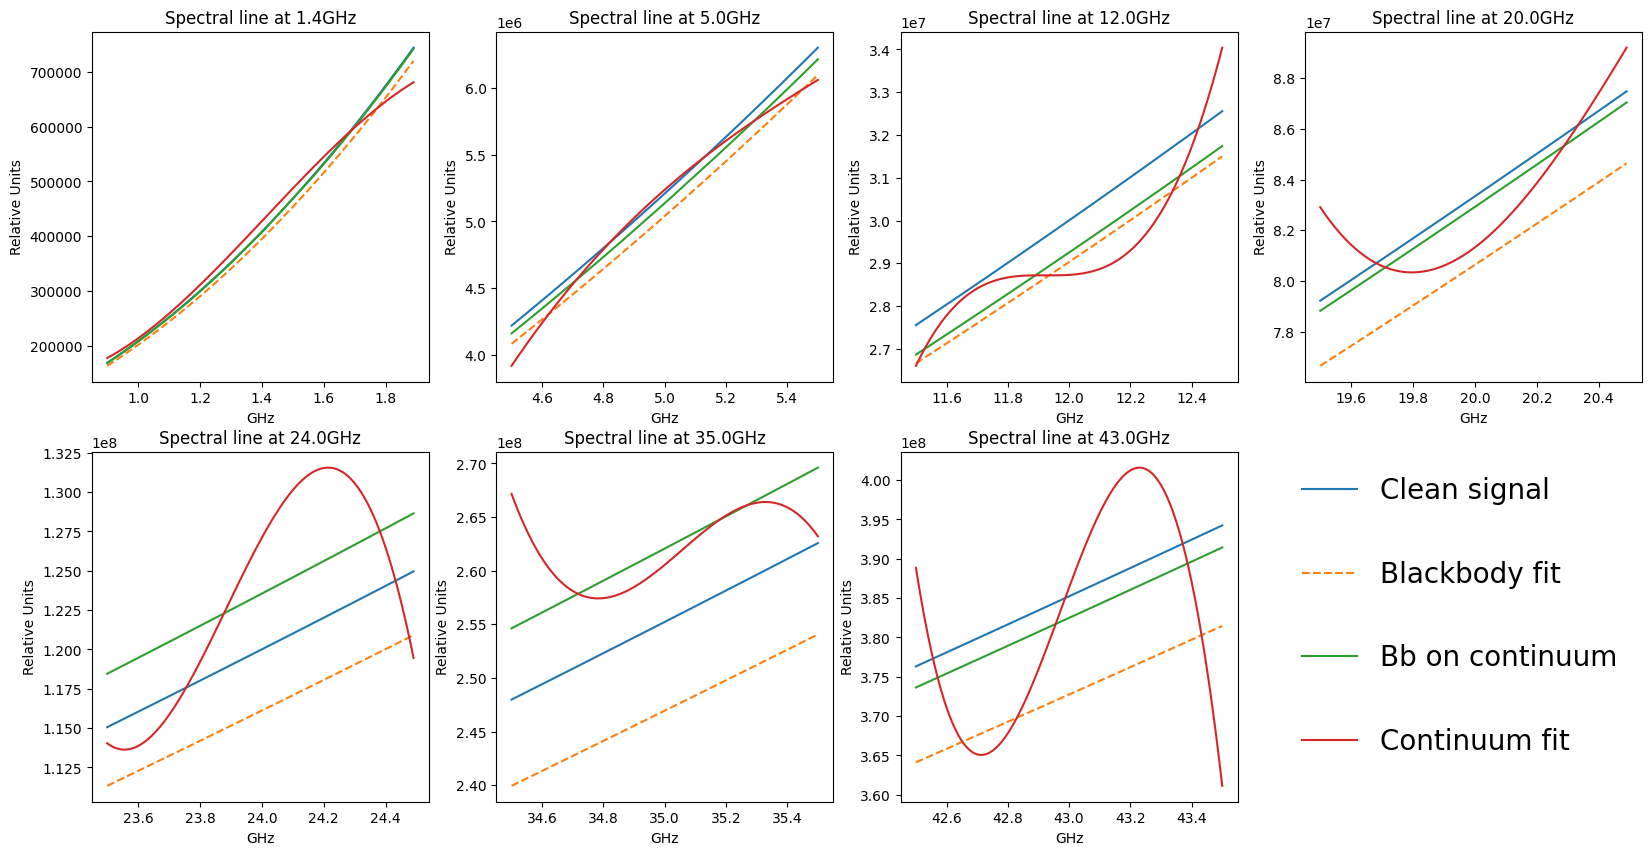

In [106]:
from scipy import optimize

def quadratic(x, a):
    return a*x**2

fig, ax = plt.subplots(2,4,figsize = (20,10))

for line in range(len(spectral_lines)):
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    # quad = False
    # if(clean[points[0]]<clean[points[-1]]):
    quad = True

    popt_fit, pcov_fit = optimize.curve_fit(Bv, df[line]['X'], df[line]['fit'])
    
    axis = ax[line//4, line%4]

    axis.plot(df[line]['X'], Bv(df[line]['X'], T), label="Clean signal")
    # axis.plot(df[line]['X'], df[line]['clean'], label="Spectral Lines")
    axis.plot(df[line]['X'], Bv(df[line]['X'], *popt), "--", label="Blackbody fit")
    axis.plot(df_edit[line]['X'], Bv(df_edit[line]['X'], *popt_fit), label = "Bb on continuum")
    axis.plot(df[line]['X'], df[line]['fit'], label="Continuum fit")
    
    handles, labels = axis.get_legend_handles_labels()
    axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
    axis.set_xlabel("GHz")
    axis.set_ylabel("Relative Units")

ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
ax[1,3].axis('off')
plt.show()

### 3.6 Calculating error of fittings

In [107]:
per_Bv = 0
per_Bv_raw = 0
per_Bv_spectral = 0
per_Bv_fit = 0
per_quad = 0
per_quad_raw = 0
per_quad_spectral = 0
per_quad_fit = 0

max_Bv = 0
max_Bv_raw = 0
max_Bv_spectral = 0
max_Bv_fit = 0
max_quad = 0
max_quad_raw = 0
max_quad_spectral = 0
max_quad_fit = 0

for line in range(len(spectral_lines)):
    quad = True
    points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    X_cords = np.array([X[j] for j in points])

    popt_Bv, pcov_Bv = optimize.curve_fit(Bv, df_edit[line]['X'], df_edit[line]['signal'])
    popt_Bv_spectral, pcov_Bv_spectral = optimize.curve_fit(Bv, X_cords, signal[points[0]: points[-1]+1])
    popt_Bv_raw, pcov_Bv_raw = optimize.curve_fit(Bv, X_cords, raw[points[0]:points[-1]+1])
    popt_Bv_fit, pcov_Bv_fit = optimize.curve_fit(Bv, df[line]['X'], df[line]['fit']) #specutils
    
    T_Bv_raw = popt_Bv_raw[0]
    if(np.abs(T-T_Bv_raw) > max_Bv_raw):
        max_Bv_raw = T_Bv_raw
    per_Bv_raw = max(np.abs(T-T_Bv_raw)/T *100, per_Bv_raw)
    T_Bv_spectral = popt_Bv_spectral[0]
    if(np.abs(T-T_Bv_spectral) > max_Bv_spectral):
        max_Bv_spectral = T_Bv_spectral
    per_Bv_spectral = max(np.abs(T-T_Bv_spectral)/T *100, per_Bv_spectral)
    T_Bv = popt_Bv[0]
    if(np.abs(T-T_Bv) > max_Bv):
        max_Bv = T_Bv
    per_Bv = max(np.abs(T-T_Bv)/T *100, per_Bv)
    T_Bv_fit = popt_Bv_fit[0]
    if(np.abs(T-T_Bv_fit) > max_Bv_fit):
        max_Bv_fit = T_Bv_fit
    per_Bv_fit = max(np.abs(T-T_Bv_fit)/T *100, per_Bv_fit)

    if(quad):
        popt_quad, pcov_quad = optimize.curve_fit(quadratic, df_edit[line]['X'], df_edit[line]['signal'])
        popt_quad_spectral, pcov_quad_spectral = optimize.curve_fit(quadratic, X_cords, signal[points[0]: points[-1]+1])
        popt_quad_raw, pcov_quad_raw = optimize.curve_fit(quadratic, X_cords, raw[points[0]:points[-1]+1])
        popt_quad_fit, pcov_quad_fit = optimize.curve_fit(quadratic, df[line]['X'], df[line]['fit']) #specutils
        
        power = 6.62607015/1.380649 *10**(-2)

        T_quad_raw = popt_quad_raw[0]*power
        if(np.abs(T-T_quad_raw) > max_quad_raw):
            max_quad_raw = T_quad_raw
        per_quad_raw = max(np.abs(T-T_quad_raw)/T *100, per_quad_raw)
        T_quad_spectral = popt_quad_spectral[0]*power
        if(np.abs(T-T_quad_spectral) > max_quad_spectral):
            max_quad_spectral = T_quad_spectral
        per_quad_spectral = max(np.abs(T-T_quad_spectral)/T *100, per_quad_spectral)
        T_quad = popt_quad[0]*power
        if(np.abs(T-T_quad) > max_quad):
            max_quad = T_quad
        per_quad = max(np.abs(T-T_quad)/T *100, per_quad)
        T_quad_fit = popt_quad_fit[0]*power
        if(np.abs(T-T_quad_fit) > max_quad_fit):
            max_quad_fit = T_quad_fit
        per_quad_fit = max(np.abs(T-T_quad_fit)/T *100, per_quad_fit)
        
    
print("Fitting with Blackbody")
print("Real temperature value:", T,"K")
print("Without Spectral Lines:", max_Bv_raw,"K", round(per_Bv_raw,2), "%")
print("With Spectral Lines:   ", max_Bv_spectral,"K", round(per_Bv_spectral,2),"%")
print("Filtered Signal:       ", max_Bv,"K", round(per_Bv,2),"%")
print("Specutils filter:      ", max_Bv_fit,"K", round(per_Bv_fit,2),"%")

print("Fitting with Quadratic")
print("Without Spectral Lines:", max_quad_raw,"K", round(per_quad_raw,2), "%")
print("With Spectral Lines:   ", max_quad_spectral,"K", round(per_quad_spectral,2),"%")
print("Filtered Signal:       ", max_quad,"K", round(per_quad,2),"%")
print("Specutils filter:      ", max_quad_fit,"K", round(per_quad_fit,2),"%")

Fitting with Blackbody
Real temperature value: 10000.0 K
Without Spectral Lines: 9957.84138947577 K 1.22 %
With Spectral Lines:    10839.64569865807 K 11.5 %
Filtered Signal:        10033.49803312432 K 4.8 %
Specutils filter:       9969.264572253453 K 2.95 %
Fitting with Quadratic
Without Spectral Lines: 9957.826906683118 K 1.21 %
With Spectral Lines:    10839.860563590222 K 11.49 %
Filtered Signal:        10033.539047340044 K 4.8 %
Specutils filter:       9969.218335911599 K 2.94 %


## 5. Fitting using specutils (Will not be used)

In [108]:
# fig, ax = plt.subplots(2,4,figsize = (20,10))
# df_edit = [df[line]['cut'].copy() for line in range(len(spectral_lines))]
# start = [0 for line in range(len(spectral_lines))]
# end = [0 for line in range(len(spectral_lines))]
# # df_integr 
# for line in range(len(spectral_lines)):
#     points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    
#     df_edit[line] = df_edit[line].dropna(axis=0, how='any')
#     # df_integr[line] = df_edit[line]
    
#     diff = df_edit[line].index[1:]-df_edit[line].index[:-1]
#     diff = pd.Series(diff, index=df_edit[line].index[:-1])
#     sorted = diff.sort_values()
    
#     # if(min(sorted.index[-1],sorted.index[-2]) <=)
#     # print(start[line]," ", end[line])
#     start[line] = min(sorted.index[-1],sorted.index[-2])
#     end[line] = max(sorted.index[-1],sorted.index[-2]) + sorted.iat[-1]
#     print(start[line]," ", end[line])
    
#     df_edit[line] = df[line][['X','median']].copy()
#     df_edit[line]['median'][start[line]:end[line]] = np.nan 
    
#     axis = ax[line//4, line%4]
#     axis.plot(df[line]['X'], spectral[points[0]:points[-1]+1], '--', label="Raw Spectral Lines")
#     axis.plot(df[line]['X'], df_edit[line]['median'], label="Cut signal")
#     axis.plot(df[line]['X'][start[line]:end[line]], df[line]['median'][start[line]:end[line]], label="Spectral line")
    

#     axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
#     axis.set_xlabel("GHz")
#     axis.set_ylabel("Relative Units")

# # print(df_edit[line]) 
# handles, labels = axis.get_legend_handles_labels()
# ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
# ax[1,3].axis('off')
# plt.show()

In [109]:
# thresh = 5
# thresh = 0.7

In [110]:
# import warnings
# from astropy.modeling import models
# import astropy.units as u
# from specutils import Spectrum1D, SpectralRegion
# from specutils.fitting import find_lines_threshold, find_lines_derivative, fit_continuum, fit_generic_continuum, fit_lines

# def quadratic(x, a):
#     return a*x**2

# # X0 = 100
# # X = np.geomspace(10e-3 , X0, 50000)
# # clean = Bv(X, T)
# # lines = clean

# # spectral_lines = np.array([1.4, 5, 12, 20, 24, 35, 43])

# units = u.erg / (u.cm ** 2 * u.s * u.Hz * u.sr)

# # Trick for now
# # noise = np.random.normal(0,spread,len(clean))/factor
# # signal = clean + noise*clean

# fig, ax = plt.subplots(2,4,figsize = (20,10))

# df = 0
# df = [pd.DataFrame({}) for line in range(len(spectral_lines))]

# for line in range(len(spectral_lines)):
#     points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
#     quad = False
#     if(signal[points[0]]<signal[points[-1]]):
#         quad = True

#     df[line]['X'] = np.array([X[j] for j in points])
#     df[line]['signal'] = signal[points[0]:points[-1]+1]
#     spectrum = Spectrum1D(flux=df[line]['signal'].to_numpy()*units, spectral_axis=df[line]['X'].to_numpy()*u.AA)

#     step = int(len(points)/divisor)

#     df_edit[line] = df[line]
#     df[line]['slope'] = df[line]['signal'].diff(step).shift(periods = -int(np.ceil(step/2)), fill_value=0).fillna(value = 0)

#     h= np.histogram(df[line]['slope'], bins=bins)
#     new_h = list()
#     bin = h[1][0]-h[1][1]

#     for j, c in enumerate(h[0]):
#         if(c >= df[line]['slope'].size*percent/100):
#             new_h.append(h[1][j])
#             last = j

#     new_h.append(max(new_h)-bin)
#     new_h = np.sort(new_h)

#     df[line]['cut'] = df[line]['slope']

#     for j, y in enumerate(df[line]['cut']):
#         if(y > new_h[-1]):
#             df[line]['cut'][j] = np.nan
#         if(y < new_h[0]):
#             df[line]['cut'][j] = np.nan

#     df_edit[line] = df_edit[line].dropna(axis=0, how='any')
    
#     diff = df_edit[line].index[1:]-df_edit[line].index[:-1]
#     diff = pd.Series(diff, index=df_edit[line].index[:-1])
#     sorted = diff.sort_values()
    
#     start = min(sorted.index[-1],sorted.index[-2])
#     end = max(sorted.index[-1],sorted.index[-2]) + sorted.iat[-1]

#     df_edit[line] = df[line][['X','signal']].copy()
#     df_edit[line]['signal'][start:end] = np.nan 

#     region = [(df[line]['X'][0]*u.AA, df[line]['X'][start]*u.AA), (df[line]['X'][end]*u.AA, df[line]['X'].iloc[-1]*u.AA)]
#     fitted_continuum = fit_continuum(spectrum, window=region)

#     df[line]['fit'] = fitted_continuum(df[line]['X'].to_numpy()*u.AA)

#     axis = ax[line//4, line%4]
#     axis.plot(spectrum.spectral_axis, spectrum.flux, label="Raw signal")
#     # axis.plot(fixed.spectral_axis, fixed.flux, label="Raw signal")
#     # axis.plot(spectrum.spectral_axis, Bv(df[line]['X'] , T), label="Raw signal")
#     # for i in lines:
#         # axis.plot(np.ones(len(df[line]['X']))*i['line_center'], np.linspace(min(fixed.flux), max(fixed.flux), len(df[line]['X'])), '--')

#     axis.plot(df[line]['X'], df[line]['fit'], label="Raw signal")
#     # axis.plot(df[line]['X'], fit(df[line]['X']*u.AA), label="Raw signal")

#     axis.plot(np.ones(len(df[line]['X']))*df[line]['X'][start], np.linspace(min(spectrum.flux), max(spectrum.flux), len(df[line]['X'])), '--')
#     axis.plot(np.ones(len(df[line]['X']))*df[line]['X'][end], np.linspace(min(spectrum.flux), max(spectrum.flux), len(df[line]['X'])), '--')

#     # axis.plot(df[line]['X'], df[line]['slope'], label="Slope of the signal")
#     # axis.plot(df[line]['X'], df[line]['cut'], label="cut signal")
#     # axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[0])
#     # axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[-1])
    
#     axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
#     axis.set_xlabel("GHz")
#     axis.set_ylabel("Relative Units")

# handles, labels = axis.get_legend_handles_labels()
# ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
# ax[1,3].axis('off')
# plt.show()

##

In [111]:
# fig, ax = plt.subplots(2,4,figsize = (20,10))
# df_edit = [df[line]['cut'].copy() for line in range(len(spectral_lines))]
# start = [0 for line in range(len(spectral_lines))]
# end = [0 for line in range(len(spectral_lines))]
# for line in range(len(spectral_lines)):
#     points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]
    
#     df_edit[line] = df_edit[line].dropna(axis=0, how='any')
    
#     diff = df_edit[line].index[1:]-df_edit[line].index[:-1]
#     diff = pd.Series(diff, index=df_edit[line].index[:-1])
#     sorted = diff.sort_values()
    
#     # if(min(sorted.index[-1],sorted.index[-2]) <=)
#     # print(start[line]," ", end[line])
#     start[line] = min(sorted.index[-1],sorted.index[-2])
#     end[line] = max(sorted.index[-1],sorted.index[-2]) + sorted.iat[-1]
#     print(start[line]," ", end[line])
    
#     df_edit[line] = df[line][['X','median']].copy()
#     df_edit[line]['median'][start[line]:end[line]] = np.nan 
    
#     axis = ax[line//4, line%4]
#     axis.plot(df[line]['X'], spectral[points[0]:points[-1]+1], '--', label="Raw Spectral Lines")
#     axis.plot(df[line]['X'], df_edit[line]['median'], label="Cut signal")
#     axis.plot(df[line]['X'][start[line]:end[line]], df[line]['median'][start[line]:end[line]], label="Spectral line")
    

#     axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
#     axis.set_xlabel("GHz")
#     axis.set_ylabel("Relative Units")

# # print(df_edit[line]) 
# handles, labels = axis.get_legend_handles_labels()
# ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
# ax[1,3].axis('off')
# plt.show()

In [112]:
# import warnings
# from astropy.modeling import models
# import astropy.units as u
# from specutils import Spectrum1D, SpectralRegion
# from specutils.fitting import find_lines_threshold, find_lines_derivative, fit_continuum, fit_generic_continuum, fit_lines

# signal = clean + noise*clean/4

# units = u.erg / (u.cm ** 2 * u.s * u.Hz * u.sr)

# fig, ax = plt.subplots(2,4,figsize = (20,10))

# df = 0
# df = [pd.DataFrame({}) for line in range(len(spectral_lines))]

# for line in range(len(spectral_lines)):
#     points = [j for j,v in enumerate(X) if (abs(v - spectral_lines[line]) <=0.5)]

#     df[line]['X'] = np.array([X[j] for j in points])
#     df[line]['signal'] = signal[points[0]:points[-1]+1]

    
#     spectrum = Spectrum1D(flux=df[line]['signal'].to_numpy()*units, spectral_axis=df[line]['X'].to_numpy()*u.AA)
#     fit = np.array(Bv(df[line]['X'] , T))*units
#     # print(fit)
#     fixed = Spectrum1D(flux=spectrum.flux/fit-1, spectral_axis=spectrum.spectral_axis)

#     with warnings.catch_warnings():  # Ignore warnings
#         warnings.simplefilter('ignore')
#         lines = find_lines_derivative(fixed, thresh)
#         # lines = find_lines_threshold(spectrum, noise_factor=thresh)

#     region = [(df[line]['X'][0]*u.AA, lines['line_center'][0]-0.1*u.AA), (lines['line_center'][0]+0.1*u.AA, df[line]['X'].iloc[-1]*u.AA)]
#     fitted_continuum = fit_continuum(spectrum, window=region)
#     # fitspec = Spectrum1D(flux=fitted_continuum(df[line]['X'].to_numpy()*u.AA), spectral_axis=df[line]['X'].to_numpy()*u.AA)
#     # fit = fit_lines(fitspec, models.BlackBody(), window=region)
#     # print(fitted_continuum)
#     # print(fit)
#     df[line]['fit'] = fitted_continuum(df[line]['X'].to_numpy()*u.AA)
#     # print(df[line]['fit'])

#     axis = ax[line//4, line%4]
#     axis.plot(spectrum.spectral_axis, spectrum.flux, label="Raw signal")
#     # axis.plot(fixed.spectral_axis, fixed.flux, label="Raw signal")
#     # axis.plot(spectrum.spectral_axis, Bv(df[line]['X'] , T), label="Raw signal")
#     # for i in lines:
#         # axis.plot(np.ones(len(df[line]['X']))*i['line_center'], np.linspace(min(fixed.flux), max(fixed.flux), len(df[line]['X'])), '--')

#     axis.plot(df[line]['X'], df[line]['fit'], label="Raw signal")
#     # axis.plot(df[line]['X'], fit(df[line]['X']*u.AA), label="Raw signal")

#     axis.plot(np.ones(len(df[line]['X']))*(lines['line_center'][0]/u.AA-0.1), np.linspace(min(spectrum.flux), max(spectrum.flux), len(df[line]['X'])), '--')
#     axis.plot(np.ones(len(df[line]['X']))*(lines['line_center'][0]/u.AA+0.1), np.linspace(min(spectrum.flux), max(spectrum.flux), len(df[line]['X'])), '--')

#     # axis.plot(df[line]['X'], df[line]['slope'], label="Slope of the signal")
#     # axis.plot(df[line]['X'], df[line]['cut'], label="cut signal")
#     # axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[0])
#     # axis.plot(df[line]['X'], np.ones(len(df[line]['X']))*new_h[-1])
    
#     axis.set_title("Spectral line at "+str(spectral_lines[line])+"GHz")
#     axis.set_xlabel("GHz")
#     axis.set_ylabel("Relative Units")

# handles, labels = axis.get_legend_handles_labels()
# ax[1,3].legend(handles, labels, labelspacing=2, fontsize = 20, frameon=False)
# ax[1,3].axis('off')
# plt.show()